# 1D harmonic oscillator physics-informed neural network (PINN)

The example problem we solve here is the 1D damped harmonic oscillator:
$$
m \dfrac{d^2 x}{d t^2} + \mu \dfrac{d x}{d t} + kx = 0~
$$
with the initial conditions
$$
x(0) = 1~~,~~\dfrac{d x}{d t} = 0~
$$
We will focus on solving the problem for the under-damped state, i.e. when 
$$
\delta < \omega_0~,~~~~~\mathrm{with}~~\delta = \dfrac{\mu}{2m}~,~\omega_0 = \sqrt{\dfrac{k}{m}}~
$$
This has the following exact solution:
$$
x(t) = e^{-\delta t}(2 A \cos(\phi + \omega t))~,~~~~~\mathrm{with}~~\omega=\sqrt{\omega_0^2 - \delta^2}~
$$


## Workflow overview

>First we will train a standard neural network to interpolate a small part of the solution, using some observed training points from the solution.

>Next, we will train a PINN to extrapolate the full solution outside of these training points by penalising the underlying differential equation in its loss function.


## MLP PINN

  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [01:03<00:00, 1584.53it/s, Loss=0.006143999] 


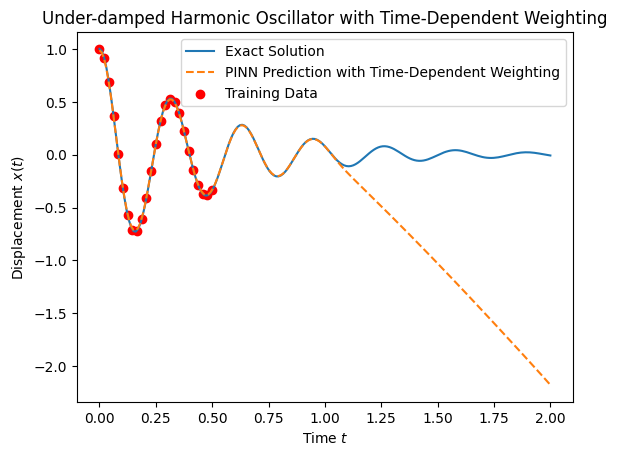

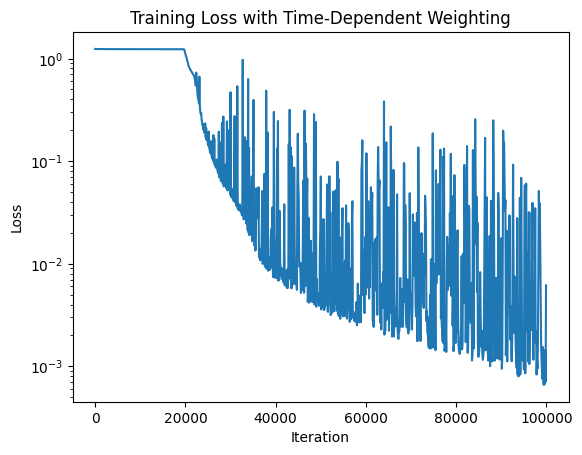

In [2]:
import numpy as np  # Original NumPy
import jax
import jax.numpy as jnp
from jax import random, grad, vmap, jit, value_and_grad
from jax.example_libraries import optimizers
from jax.flatten_util import ravel_pytree
from functools import partial
import matplotlib.pyplot as plt
from tqdm import trange
import itertools

# Define the exact solution of the underdamped harmonic oscillator
def oscillator(d, w0, t):
    w = jnp.sqrt(w0 ** 2 - d ** 2)
    phi = jnp.arctan(-d / w)
    A = 1.0 / (2.0 * jnp.cos(phi))
    cos_term = jnp.cos(phi + w * t)
    exp_term = jnp.exp(-d * t)
    x = exp_term * 2 * A * cos_term
    return x

# Define the MLP function
def MLP(layers, activation=jnp.tanh):
    def init(rng_key):
        def init_layer(key, d_in, d_out):
            k1, _ = random.split(key)
            glorot_stddev = 1.0 / jnp.sqrt((d_in + d_out) / 2.)
            W = glorot_stddev * random.normal(k1, (d_in, d_out))
            b = jnp.zeros(d_out)
            return W, b
        keys = random.split(rng_key, len(layers))
        params = list(map(init_layer, keys, layers[:-1], layers[1:]))
        return params

    def apply(params, ijnputs):
        H = ijnputs
        for W, b in params[:-1]:
            outputs = jnp.dot(H, W) + b
            H = activation(outputs)
        W, b = params[-1]
        outputs = jnp.dot(H, W) + b
        return outputs

    return init, apply

# Define the PINN model class with time-dependent weighting
class PINN:
    def __init__(self, key, layers, mu, k, act=jnp.tanh):

        # Initialize the neural network
        self.init, self.apply = MLP(layers, activation=act)
        params = self.init(rng_key=key)
        _, self.unravel = ravel_pytree(params)

        # Use optimizers to set optimizer initialization and update functions
        lr = optimizers.exponential_decay(1e-3, decay_steps=5000, decay_rate=0.9999999999)
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(lr)
        self.opt_state = self.opt_init(params)

        # Logger
        self.itercount = itertools.count()

        self.loss_log = []

        # Constants
        self.mu = mu
        self.k = k

        # Decay rate for time-dependent weighting
        self.lambda_decay = 1.0  # You can adjust this value

    def neural_net(self, params):
        def net_apply(t):
            outputs = self.apply(params, t.reshape(-1, 1))
            return outputs.squeeze()  # Ensure output is a scalar
        return net_apply

    def residual_net(self, params):
        net_apply = self.neural_net(params)
        def res_apply(t):
            x = net_apply(t)
            x_t = grad(net_apply)(t)
            x_tt = grad(grad(net_apply))(t)
            residual = x_tt + self.mu * x_t + self.k * x
            return residual
        return res_apply

    @partial(jit, static_argnums=(0,))
    def loss(self, params, t_r, t_data, x_data):
        # Residual loss with time-dependent weighting
        res_apply = self.residual_net(params)
        residual_fn = vmap(res_apply)
        res = residual_fn(t_r)
        res_squared = res ** 2
        loss_res = jnp.sum(res_squared)

        # Data loss (at observed data points)
        net_apply = self.neural_net(params)
        x_pred = vmap(net_apply)(t_data)
        loss_data = jnp.mean((x_pred - x_data) ** 2)

        # Initial condition loss
        x0_pred = net_apply(jnp.array(0.0))
        x0_t_pred = grad(net_apply)(jnp.array(0.0))
        loss_ic = (x0_pred - 1.0) ** 2 + (x0_t_pred - 0.0) ** 2

        # Total loss
        total_loss = 1.e-4*loss_res + loss_data + loss_ic

        return total_loss

    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, t_r, t_data, x_data):
        params = self.get_params(opt_state)
        value, grads = value_and_grad(self.loss)(params, t_r, t_data, x_data)
        opt_state = self.opt_update(i, grads, opt_state)
        return opt_state, value

    def train(self, nIter, t_r, t_data, x_data):
        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            self.current_count = next(self.itercount)
            self.opt_state, loss_value = self.step(self.current_count, self.opt_state, t_r, t_data, x_data)

            if it % 100 == 0:
                self.loss_log.append(loss_value)
                pbar.set_postfix({'Loss': loss_value})

# Constants for the underdamped harmonic oscillator
d = 2.0
w0 = 20.0
mu = 2 * d
k = w0 ** 2

# Generate collocation points and data points
t_r = jnp.linspace(0.0, 1.0, 100)          # Collocation points for residual
t_data = jnp.linspace(0.0, 0.5, 25)        # Data points for initial training
x_data = oscillator(d, w0, t_data)        # Exact solution at data points

# Initialize the model
key = random.PRNGKey(0)
layers = [1, 4096, 32, 1]
model = PINN(key, layers, mu, k, act=jax.nn.gelu)

# Convert data to appropriate types
t_r = jnp.array(t_r)
t_data = jnp.array(t_data)
x_data = jnp.array(x_data)

# Adjust the decay rate as needed
model.lambda_decay = 1.0  # You can experiment with different values

# Train the model
model.train(nIter=100000, t_r=t_r, t_data=t_data, x_data=x_data)

# Evaluate the model
params = model.get_params(model.opt_state)
t_test = jnp.linspace(0.0, 2.0, 200)
t_test = jnp.array(t_test)
net_apply = model.neural_net(params)
x_pred = vmap(net_apply)(t_test)
x_exact = oscillator(d, w0, t_test)

# Plot the results
plt.figure()
plt.plot(t_test, x_exact, label='Exact Solution')
plt.plot(t_test, x_pred, '--', label='PINN Prediction with Time-Dependent Weighting')
plt.scatter(t_data, x_data, color='red', label='Training Data')
plt.legend()
plt.xlabel('Time $t$')
plt.ylabel('Displacement $x(t)$')
plt.title('Under-damped Harmonic Oscillator with Time-Dependent Weighting')
plt.show()

# Plot the training loss
plt.figure()
plt.plot(np.arange(len(model.loss_log))*100, model.loss_log)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Training Loss with Time-Dependent Weighting')
plt.show()


## SPINN (work in progress)

  6%|▌         | 5790/100000 [00:02<00:17, 5257.25it/s]

Epoch 5000/100000, Loss = 1.25263e-01


 11%|█         | 10510/100000 [00:03<00:17, 4993.46it/s]

Epoch 10000/100000, Loss = 3.62532e-01


 16%|█▌        | 15915/100000 [00:04<00:15, 5442.93it/s]

Epoch 15000/100000, Loss = 1.13273e-02


 21%|██        | 20721/100000 [00:05<00:14, 5303.90it/s]

Epoch 20000/100000, Loss = 1.06902e-02


 26%|██▌       | 25960/100000 [00:06<00:14, 5187.35it/s]

Epoch 25000/100000, Loss = 1.09354e-02


 31%|███       | 30680/100000 [00:07<00:13, 5190.10it/s]

Epoch 30000/100000, Loss = 9.58345e-03


 36%|███▌      | 35589/100000 [00:08<00:11, 5403.77it/s]

Epoch 35000/100000, Loss = 1.43593e-03


 41%|████      | 41001/100000 [00:09<00:11, 5288.21it/s]

Epoch 40000/100000, Loss = 1.06707e-03


 46%|████▌     | 45901/100000 [00:10<00:10, 5263.15it/s]

Epoch 45000/100000, Loss = 1.30339e-03


 51%|█████     | 50793/100000 [00:11<00:09, 5395.89it/s]

Epoch 50000/100000, Loss = 2.54459e-03


 56%|█████▌    | 55721/100000 [00:11<00:08, 5330.19it/s]

Epoch 55000/100000, Loss = 4.52742e-04


 61%|██████    | 60680/100000 [00:12<00:07, 5291.93it/s]

Epoch 60000/100000, Loss = 7.53051e-04


 66%|██████▌   | 65561/100000 [00:13<00:06, 5427.14it/s]

Epoch 65000/100000, Loss = 4.15941e-04


 71%|███████   | 70979/100000 [00:14<00:05, 5433.07it/s]

Epoch 70000/100000, Loss = 3.08914e-03


 76%|███████▌  | 75910/100000 [00:15<00:04, 5432.65it/s]

Epoch 75000/100000, Loss = 1.43592e-03


 81%|████████  | 80734/100000 [00:16<00:03, 5272.65it/s]

Epoch 80000/100000, Loss = 2.82879e-04


 86%|████████▌ | 85550/100000 [00:17<00:02, 5342.41it/s]

Epoch 85000/100000, Loss = 1.59762e-02


 91%|█████████ | 91018/100000 [00:18<00:01, 5398.84it/s]

Epoch 90000/100000, Loss = 2.04305e-03


 96%|█████████▌| 95956/100000 [00:19<00:00, 5434.86it/s]

Epoch 95000/100000, Loss = 1.52268e-04


100%|██████████| 100000/100000 [00:20<00:00, 4922.40it/s]


Epoch 100000/100000, Loss = 1.28626e-04
Training took 0.20 ms/iter
Relative L2 error on [0, 1.0] ~ 1.17e-02


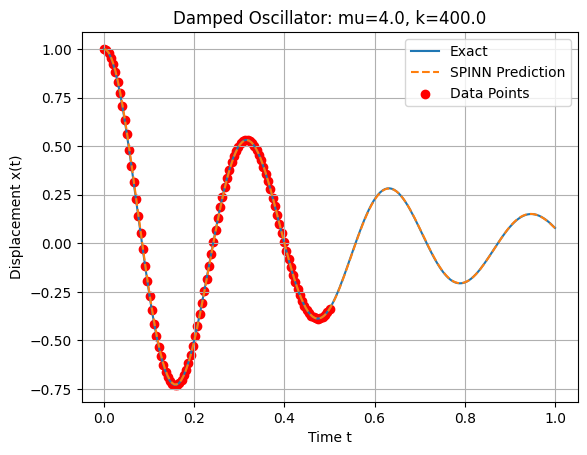

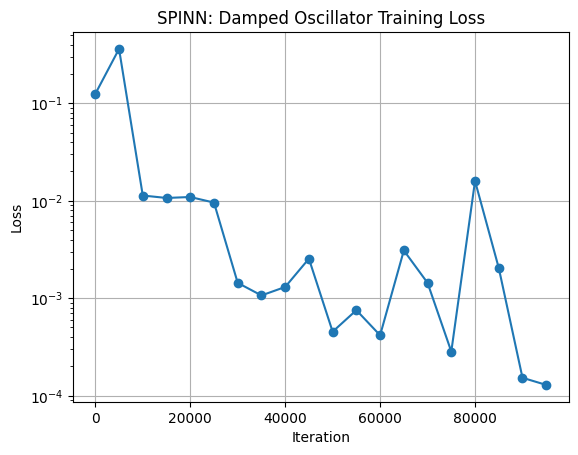

In [12]:
import os
import time
import jax
import jax.numpy as jnp
import optax
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from jax import jvp, value_and_grad
from flax import linen as nn
from typing import Sequence
from functools import partial

###############################################################################
# 1) SPINN for the damped harmonic oscillator (1D)
###############################################################################
class SPINN_osc(nn.Module):
    """
    SPINN for 1D. We only have one input dimension t.
    `features`: list/tuple specifying widths of each layer.
    Example: features=[64,64,1] => two hidden layers with 64 units each, then output layer with 1 unit.
    """
    features: Sequence[int]

    @nn.compact
    def __call__(self, t):
        """
        t: shape (N,1) or (N,) - we will handle shape carefully
        Returns: shape (N,) or (N,1) for the solution x(t)
        """
        # Just like the original code, we do a feedforward pass:
        # (1) Possibly broadcast t to shape (N,1)
        if t.ndim == 1:
            t = t[:, None]  # shape (N,1)

        init = nn.initializers.glorot_normal()
        X = t
        # hidden layers
        for fs in self.features[:-1]:
            X = nn.Dense(fs, kernel_init=init)(X)
            X = nn.swish(X)
        # final layer
        X = nn.Dense(self.features[-1], kernel_init=init)(X)
        # flatten from (N,1) => (N,)
        return X.squeeze(axis=-1)


###############################################################################
# 2) Hessian-Vector Product for second derivative in 1D
###############################################################################
def hvp_fwdfwd_1d(f, primals, tangents, return_primals=False):
    """
    Forward-mode Hessian-vector product in 1D for PDE residuals.
    This is the same pattern as hvp_fwdfwd in the 3D version, but simplified.
    
    f: function R->R, we want d^2 f/dt^2
    primals: (t,)
    tangents: (1,) usually jnp.ones((N,1)) or broadcast
    """
    g = lambda p: jvp(f, (p,), tangents)[1]  # derivative of f w.r.t p
    primals_out, tangents_out = jvp(g, primals, tangents)
    return (primals_out, tangents_out) if return_primals else tangents_out


###############################################################################
# 3) Loss function for the damped oscillator PDE
###############################################################################
def spinn_loss_damped_oscillator(apply_fn, mu, k):
    """
    PDE: x'' + mu x' + k x = 0
    We define a function that returns PDE-residual + initial cond + data losses.
    """

    def _pde_residual(params, t_c):
        """
        PDE residual over collocation points t_c.
        PDE: x_tt + mu x_t + k x = 0
        """
        # x(t)
        u = apply_fn(params, t_c)  # shape (Nc,)
        # We want second derivative in t.
        # We'll do x_tt via hvp. Also x'(t).
        v = jnp.ones_like(t_c)
        
        # x'(t) = derivative of apply_fn wrt t
        # jvp(f, (t_c,), (v,)) gives df/dt.
        # let's define f(t) = apply_fn(params, t)
        def f(t):
            return apply_fn(params, t)

        # x'(t)
        x_t = jvp(f, (t_c,), (v,))[1]

        # x''(t)
        x_tt = hvp_fwdfwd_1d(f, (t_c,), (v,))

        # PDE residual => x_tt + mu x_t + k x
        res = x_tt + mu * x_t + k * u
        return jnp.mean(res**2)  # MSE over collocation points

    def _initial_loss(params, t0):
        """
        For the oscillator, we typically have x(0)=1, x'(0)=0.
        We'll treat t0 as a single float or 0D array for t=0.
        """
        # x(0)
        x0 = apply_fn(params, t0)  # shape (1,) or scalar
        # x'(0)
        v = jnp.ones_like(t0)  # shape (1,)
        def f(t):
            return apply_fn(params, t)
        x0_t = jvp(f, (t0,), (v,))[1]
        # we want (x(0)-1)^2 + (x'(0) - 0)^2
        return jnp.sum((x0 - 1.0)**2 + (x0_t - 0.0)**2)

    def _data_loss(params, t_d, x_d):
        """
        MSE vs. some known data (maybe from exact solution).
        """
        pred = apply_fn(params, t_d)
        return jnp.mean((pred - x_d)**2)

    def loss_fn(params, t_c, t0, t_d, x_d):
        """
        Combine PDE collocation + initial condition + data matching.
        """
        return 1e-4 * _pde_residual(params, t_c) \
             + _initial_loss(params, t0) \
             + _data_loss(params, t_d, x_d)

    return loss_fn


###############################################################################
# 4) Simple data generator for the damped oscillator
###############################################################################
def spinn_train_generator_damped_oscillator(n_colloc, n_data, T, mu, k, key):
    """
    Returns:
      - t_c: collocation points in [0, T]
      - t0: for initial condition
      - t_d, x_d: data points from the exact solution
    """
    # We'll define an "underdamped" oscillator with d>0 => mu=2*d, w0^2 = k, etc.
    # but you can adapt for any damping regime.

    # collocation points
    t_c = jax.random.uniform(key, (n_colloc, 1), minval=0.0, maxval=T).squeeze(-1)  # shape (n_colloc,)
    t_c = jax.lax.stop_gradient(t_c)  # don't backprop through this
    # initial condition at t0=0
    t0 = jnp.array([0.0])  # shape (1,)
    t0 = jax.lax.stop_gradient(t0)  # don't backprop through this

    # data points
    t_d = jnp.linspace(0, T/2, n_data)  # shape (n_data,)
    t_d = jax.lax.stop_gradient(t_d)  # don't backprop through this
    
    # exact solution => x(t) = e^{-d t} * 2A cos(...) or an official formula
    # We'll define a simple function here:
    def exact_solution(t, d, w0):
        # x(t) = e^{-d t} * 2*A*cos(w t + phi)? 
        # For simplicity, let's just do x(0)=1 => 
        # We'll define the same oscillator(d, w0, t) from your prior code:
        w = jnp.sqrt(w0**2 - d**2)
        phi = jnp.arctan(-d / w)
        A = 1.0/(2.0*jnp.cos(phi))
        cos_term = jnp.cos(phi + w*t)
        exp_term = jnp.exp(-d*t)
        return exp_term*2*A*cos_term

    # we have mu=2*d => d=mu/2, w0^2=k => w0=jnp.sqrt(k).
    d = mu / 2
    w0 = jnp.sqrt(k)
    x_d = exact_solution(t_d, d, w0)  # shape (n_data,)

    return t_c, t0, t_d, x_d


###############################################################################
# 5) Putting it all together in main()
###############################################################################
def main_damped_oscillator(
    n_colloc=64,
    n_data=25,
    T=1.0,
    mu=4.0,
    k=20.0,
    seed=0,
    lr=1e-3,
    epochs=20000,
    n_layers=4,
    width=64,
    log_iter=2000
):
    """
    Example main function demonstrating how to train the SPINN_osc
    on the damped oscillator PDE: x'' + mu x' + k x = 0.
    """
    # fix GPU usage 
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

    key = jax.random.PRNGKey(seed)
    # network
    feature_sizes = [width]*(n_layers - 1) + [1]  # last layer => 1 output
    model = SPINN_osc(features=feature_sizes)

    # init model
    # We'll initialize with dummy shape (N,1) => let's do N=2
    t_dummy = jnp.ones((2,1))
    params = model.init(key, t_dummy)

    # optimizer
    optim = optax.adam(lr)
    state = optim.init(params)

    # PDE + data
    key, subkey = jax.random.split(key)
    t_c, t0, t_d, x_d = spinn_train_generator_damped_oscillator(n_colloc, n_data, T, mu, k, subkey)
    
    # define PDE loss
    apply_fn = partial(model.apply)
    loss_fn = spinn_loss_damped_oscillator(apply_fn, mu, k)

    @partial(jax.jit, static_argnums=(0,))
    def train_step(loss_f, params, state):
        # single step 
        # collocation points, t0, data, etc. are captured from outer scope
        loss, grads = value_and_grad(loss_f)(params, t_c, t0, t_d, x_d)
        updates, state = optim.update(grads, state)
        params = optax.apply_updates(params, updates)
        return loss, params, state

    # training loop
    losses = []
    tic = time.time()
    for i in trange(1, epochs+1):
        loss_val, params, state = train_step(loss_fn, params, state)
        if i % log_iter == 0:
            losses.append(float(loss_val))
            print(f"Epoch {i}/{epochs}, Loss = {loss_val:.5e}")
    toc = time.time()
    print(f"Training took {(toc - tic)/epochs*1000:.2f} ms/iter")

    # final solution + plots
    # Evaluate on a test grid
    t_test = jnp.linspace(0.0, T, 200)
    x_pred = apply_fn(params, t_test)  # shape (200,)

    # Compare with exact solution
    d = mu / 2
    w0 = jnp.sqrt(k)
    def exact_solution(t, d, w0):
        w = jnp.sqrt(w0**2 - d**2)
        phi = jnp.arctan(-d / w)
        A = 1.0/(2.0*jnp.cos(phi))
        cos_term = jnp.cos(phi + w*t)
        exp_term = jnp.exp(-d*t)
        return exp_term*2*A*cos_term

    x_exact = exact_solution(t_test, d, w0)
    # L2 error
    l2_rel = jnp.linalg.norm(x_pred - x_exact)/jnp.linalg.norm(x_exact)
    print(f"Relative L2 error on [0, {T}] ~ {l2_rel:.2e}")

    # quick plot
    plt.figure()
    plt.plot(t_test, x_exact, label='Exact')
    plt.plot(t_test, x_pred, '--', label='SPINN Prediction')
    plt.scatter(t_d, x_d, color='red', label='Data Points')
    plt.title(f"Damped Oscillator: mu={mu}, k={k}")
    plt.xlabel("Time t")
    plt.ylabel("Displacement x(t)")
    plt.legend()
    plt.grid(True)
    plt.show()

    # plot losses
    plt.figure()
    plt.plot(np.arange(len(losses))*log_iter, losses, 'o-')
    plt.yscale('log')
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.title("SPINN: Damped Oscillator Training Loss")
    plt.grid(True)
    plt.show()

    return l2_rel


###############################################################################
# 6) Running the script
###############################################################################
if __name__ == "__main__":
    main_damped_oscillator(
        n_colloc=64,
        n_data=100,
        T=1.0,     # final time
        mu=4.0,    # e.g. 2*d => d=2 => mu=4
        k=400.0,   # e.g. w0^2=400 => w0=20
        seed=1234,
        lr=1e-3,
        epochs=100000,
        n_layers=4,
        width=128,
        log_iter=5000
    )


[I 2025-01-06 13:20:01,800] A new study created in RDB with name: spinn_study_20250106_132001


Starting study 'spinn_study_20250106_132001' with DB file 'spinn_study_20250106_132001.db'.


  5%|▌         | 5112/100000 [00:09<02:15, 699.73it/s]

Epoch 5000/100000, Loss = 1.88159e-03


 10%|█         | 10105/100000 [00:16<02:04, 719.54it/s]

Epoch 10000/100000, Loss = 3.74181e-05


 15%|█▌        | 15104/100000 [00:23<01:58, 717.59it/s]

Epoch 15000/100000, Loss = 2.40669e-04


 20%|██        | 20104/100000 [00:30<01:51, 717.89it/s]

Epoch 20000/100000, Loss = 1.62884e-05


 25%|██▌       | 25105/100000 [00:38<01:44, 719.99it/s]

Epoch 25000/100000, Loss = 5.30254e-06


 30%|███       | 30104/100000 [00:45<01:37, 716.02it/s]

Epoch 30000/100000, Loss = 1.52189e-06


 35%|███▌      | 35104/100000 [00:52<01:29, 723.62it/s]

Epoch 35000/100000, Loss = 3.23303e-05


 40%|████      | 40104/100000 [00:59<01:23, 721.28it/s]

Epoch 40000/100000, Loss = 2.18207e-05


 45%|████▌     | 45107/100000 [01:06<01:16, 718.01it/s]

Epoch 45000/100000, Loss = 5.52064e-07


 50%|█████     | 50106/100000 [01:13<01:09, 717.32it/s]

Epoch 50000/100000, Loss = 1.21992e-06


 55%|█████▌    | 55106/100000 [01:20<01:02, 717.58it/s]

Epoch 55000/100000, Loss = 2.92118e-06


 60%|██████    | 60105/100000 [01:27<00:55, 717.90it/s]

Epoch 60000/100000, Loss = 7.94287e-08


 65%|██████▌   | 65105/100000 [01:35<00:48, 719.58it/s]

Epoch 65000/100000, Loss = 2.70929e-07


 70%|███████   | 70105/100000 [01:42<00:41, 717.07it/s]

Epoch 70000/100000, Loss = 2.17005e-06


 75%|███████▌  | 75106/100000 [01:49<00:34, 716.32it/s]

Epoch 75000/100000, Loss = 7.91773e-07


 80%|████████  | 80105/100000 [01:56<00:27, 716.02it/s]

Epoch 80000/100000, Loss = 7.70485e-06


 85%|████████▌ | 85104/100000 [02:03<00:20, 718.13it/s]

Epoch 85000/100000, Loss = 2.54412e-06


 90%|█████████ | 90105/100000 [02:10<00:13, 720.26it/s]

Epoch 90000/100000, Loss = 1.14385e-07


 95%|█████████▌| 95102/100000 [02:17<00:06, 710.21it/s]

Epoch 95000/100000, Loss = 2.20260e-07


100%|██████████| 100000/100000 [02:24<00:00, 690.32it/s]


Epoch 100000/100000, Loss = 1.75266e-06
Training took 1.45 ms/iter
Relative L2 error on [0, 1.0] ~ 1.91e-03


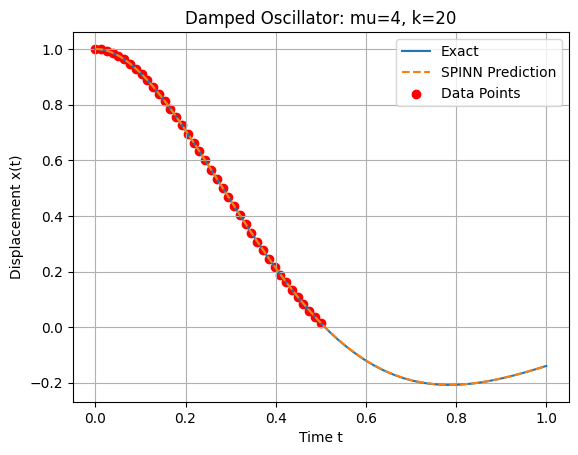

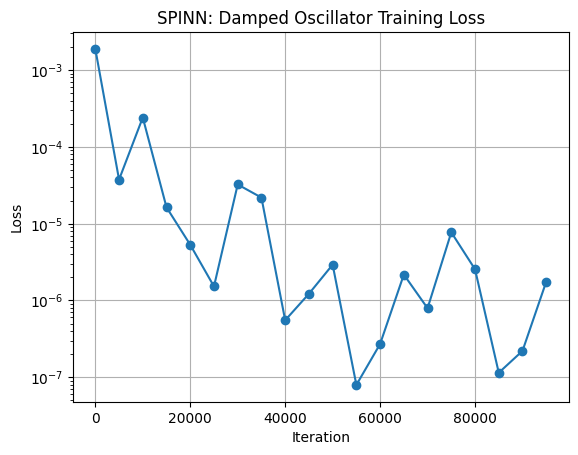

[I 2025-01-06 13:22:28,390] Trial 0 finished with value: 0.0019079421181231737 and parameters: {'n_colloc': 496, 'n_data': 40, 'n_layers': 7, 'width': 144}. Best is trial 0 with value: 0.0019079421181231737.
  5%|▌         | 5127/100000 [00:08<02:01, 783.53it/s]

Epoch 5000/100000, Loss = 1.26178e-04


 10%|█         | 10126/100000 [00:14<01:54, 784.92it/s]

Epoch 10000/100000, Loss = 1.84749e-05


 15%|█▌        | 15125/100000 [00:20<01:47, 786.26it/s]

Epoch 15000/100000, Loss = 7.93650e-05


 20%|██        | 20106/100000 [00:27<01:41, 784.88it/s]

Epoch 20000/100000, Loss = 7.82037e-05


 25%|██▌       | 25108/100000 [00:33<01:34, 795.16it/s]

Epoch 25000/100000, Loss = 1.17349e-05


 30%|███       | 30133/100000 [00:40<01:28, 785.45it/s]

Epoch 30000/100000, Loss = 3.32523e-06


 35%|███▌      | 35151/100000 [00:46<01:22, 785.25it/s]

Epoch 35000/100000, Loss = 5.64719e-07


 40%|████      | 40107/100000 [00:52<01:15, 793.06it/s]

Epoch 40000/100000, Loss = 1.83970e-07


 45%|████▌     | 45130/100000 [00:59<01:10, 783.11it/s]

Epoch 45000/100000, Loss = 1.93931e-06


 50%|█████     | 50151/100000 [01:05<01:03, 781.89it/s]

Epoch 50000/100000, Loss = 2.63910e-06


 55%|█████▌    | 55157/100000 [01:11<00:56, 789.52it/s]

Epoch 55000/100000, Loss = 5.18194e-07


 60%|██████    | 60107/100000 [01:18<00:50, 794.99it/s]

Epoch 60000/100000, Loss = 1.88693e-06


 65%|██████▌   | 65140/100000 [01:24<00:44, 787.56it/s]

Epoch 65000/100000, Loss = 7.69897e-07


 70%|███████   | 70105/100000 [01:30<00:37, 798.69it/s]

Epoch 70000/100000, Loss = 5.87697e-07


 75%|███████▌  | 75141/100000 [01:37<00:31, 787.03it/s]

Epoch 75000/100000, Loss = 3.38720e-06


 80%|████████  | 80106/100000 [01:43<00:24, 798.80it/s]

Epoch 80000/100000, Loss = 2.50214e-05


 85%|████████▌ | 85145/100000 [01:49<00:18, 787.28it/s]

Epoch 85000/100000, Loss = 3.32024e-07


 90%|█████████ | 90108/100000 [01:56<00:12, 791.17it/s]

Epoch 90000/100000, Loss = 3.54106e-06


 95%|█████████▌| 95125/100000 [02:02<00:06, 775.61it/s]

Epoch 95000/100000, Loss = 3.48597e-07


100%|██████████| 100000/100000 [02:08<00:00, 776.32it/s]


Epoch 100000/100000, Loss = 2.85821e-07
Training took 1.29 ms/iter
Relative L2 error on [0, 1.0] ~ 7.07e-05


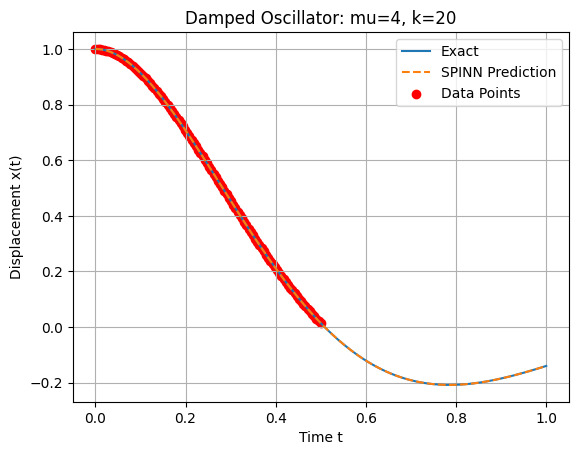

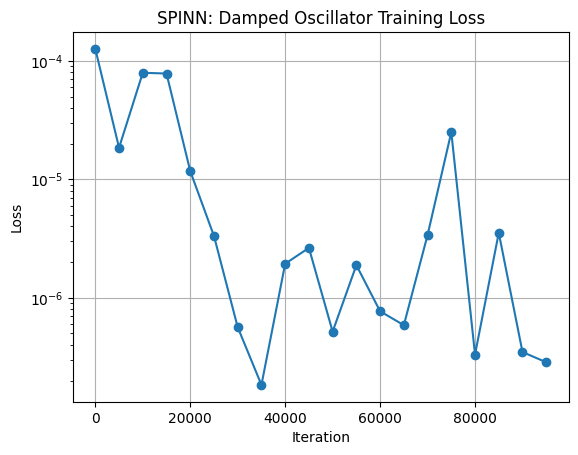

[I 2025-01-06 13:24:37,873] Trial 1 finished with value: 7.068592822179198e-05 and parameters: {'n_colloc': 576, 'n_data': 104, 'n_layers': 6, 'width': 192}. Best is trial 1 with value: 7.068592822179198e-05.
  5%|▌         | 5084/100000 [00:12<03:03, 516.41it/s]

Epoch 5000/100000, Loss = 1.26192e-03


 10%|█         | 10091/100000 [00:22<03:00, 498.43it/s]

Epoch 10000/100000, Loss = 7.62876e-04


 15%|█▌        | 15089/100000 [00:32<02:48, 504.78it/s]

Epoch 15000/100000, Loss = 2.64908e-04


 20%|██        | 20089/100000 [00:42<02:39, 500.55it/s]

Epoch 20000/100000, Loss = 2.04239e-04


 25%|██▌       | 25088/100000 [00:52<02:29, 500.49it/s]

Epoch 25000/100000, Loss = 1.69657e-06


 30%|███       | 30088/100000 [01:02<02:18, 505.05it/s]

Epoch 30000/100000, Loss = 1.39143e-05


 35%|███▌      | 35090/100000 [01:12<02:09, 501.86it/s]

Epoch 35000/100000, Loss = 2.09282e-06


 38%|███▊      | 38121/100000 [01:18<02:08, 482.57it/s]
[W 2025-01-06 13:25:57,411] Trial 2 failed with parameters: {'n_colloc': 752, 'n_data': 72, 'n_layers': 8, 'width': 176} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/home/mitch/miniconda3/envs/phd/lib/python3.9/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_99100/256756460.py", line 22, in objective
    rel_l2_err = main_damped_oscillator(
  File "/tmp/ipykernel_99100/913846146.py", line 238, in main_damped_oscillator
    loss_val, params, state = train_step(loss_fn, params, state)
  File "<string>", line 1, in <lambda>
KeyboardInterrupt
[W 2025-01-06 13:25:57,413] Trial 2 failed with value None.


KeyboardInterrupt: 

In [16]:
import optuna
import datetime
import os

def objective(trial: optuna.Trial) -> float:
    """
    Objective function that picks hyperparameters and returns a scalar metric to minimize.
    For example, a final validation loss or some PDE error.
    """

    # 1) Suggest hyperparameters
    n_colloc = trial.suggest_int("n_colloc", 16, 2048, step=16)
    n_data   = trial.suggest_int("n_data",   8,  128, step=8)
    # mu       = trial.suggest_float("mu",     0.1, 10.0, log=True)
    # k        = trial.suggest_float("k",      10.0, 500.0, log=True)
    n_layers = trial.suggest_int("n_layers", 1, 10)
    width    = trial.suggest_int("width",    16, 256, step=16)

    # 2) Fixed number of epochs (per the request)
    epochs = 100000

    rel_l2_err = main_damped_oscillator(
        n_colloc=n_colloc,
        n_data=n_data,
        T=1.0,     # final time
        mu=4,    # e.g. 2*d => d=2 => mu=4
        k=400,   # e.g. w0^2=400 => w0=20
        seed=1234,
        lr=1e-3,
        epochs=epochs,
        n_layers=n_layers,
        width=width,
        log_iter=5000
    )

    # 4) Return the scalar objective (Optuna will minimize this)
    return rel_l2_err

def main():
    # Create a unique database and study name
    dt_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    db_name = f"spinn_study_{dt_str}.db"
    study_name = f"spinn_study_{dt_str}"

    # Create the Optuna study with random sampling
    study = optuna.create_study(
        study_name=study_name,
        storage=f"sqlite:///{db_name}",
        direction="minimize",
        sampler=optuna.samplers.RandomSampler(),  # random sampling
        load_if_exists=False
    )

    # Define how many trials you want
    n_trials = 10  # or more, e.g. 50, 100, etc.

    print(f"Starting study '{study_name}' with DB file '{db_name}'.")
    study.optimize(objective, n_trials=n_trials)

    # Print best result
    print("Best trial:")
    trial = study.best_trial
    print(f"  Value: {trial.value}")
    print("  Params: ")
    for key, value in trial.params.items():
        print(f"    {key}: {value}")

if __name__ == "__main__":
    main()


## MAMBA PINN (work in progress)

100%|██████████| 10000/10000 [01:02<00:00, 160.93it/s, Loss=0.6732013]


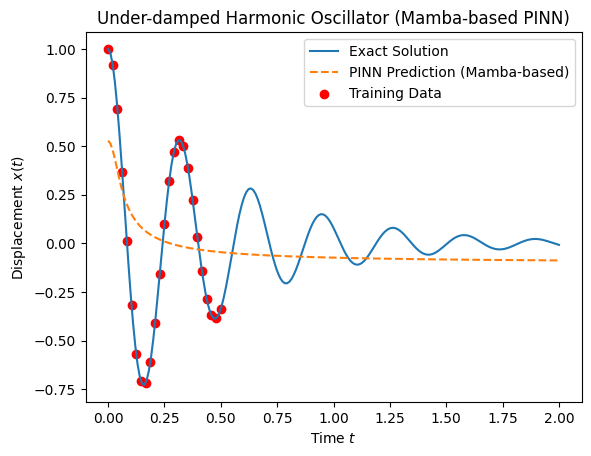

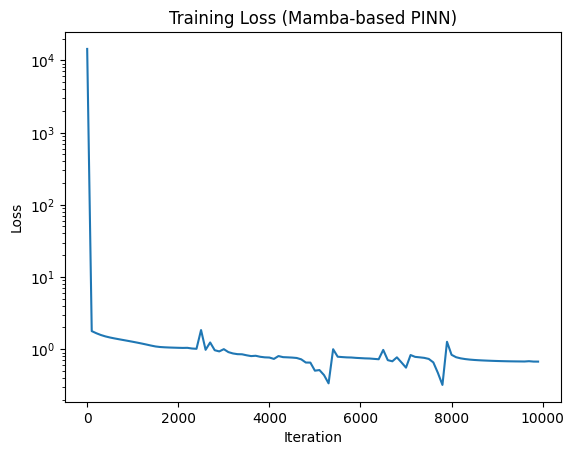

In [ ]:
import numpy as np  # Original NumPy
import jax
import jax.numpy as jnp
from jax import random, grad, vmap, jit, value_and_grad
from jax.example_libraries import optimizers
from jax.flatten_util import ravel_pytree
from functools import partial
import matplotlib.pyplot as plt
from tqdm import trange
import itertools

################################################################################
#                   MAMBA-PINN (Adapted for continuous inputs)                  #
################################################################################

from dataclasses import dataclass
from typing import Union
import math

import flax
from flax import linen as nn
from flax.linen.initializers import normal as flax_normal

@dataclass
class ModelArgs:
    """
    We will adapt Mamba's arguments to a simple continuous input use-case
    and produce a single output dimension. 
    """
    d_model: int       # hidden dim
    n_layer: int       # number of layers
    d_state: int = 16  # latent state dim
    expand: int = 2
    dt_rank: Union[int, str] = 'auto'
    d_conv: int = 4 
    conv_bias: bool = True
    bias: bool = False

    def __post_init__(self):
        self.d_inner = int(self.expand * self.d_model)
        if self.dt_rank == 'auto':
            self.dt_rank = math.ceil(self.d_model / 16)


class RMSNorm(nn.Module):
    d_model: int
    eps: float = 1e-5

    @nn.compact
    def __call__(self, x):
        weight = self.param('weight', nn.initializers.ones, (self.d_model,))
        normed = x * jax.lax.rsqrt(jnp.mean(x**2, axis=-1, keepdims=True) + self.eps)
        return normed * weight


class MambaBlock(nn.Module):
    args: ModelArgs

    def setup(self):
        self.in_proj = nn.Dense(
            features=self.args.d_inner * 2,
            kernel_init=flax_normal(),
            use_bias=self.args.bias
        )
        # Depthwise convolution
        self.conv1d = nn.Conv(
            features=self.args.d_inner,
            kernel_size=[self.args.d_conv],
            feature_group_count=self.args.d_inner,
            padding=self.args.d_conv - 1,
            use_bias=self.args.conv_bias
        )
        # x_proj: produces input-specific Δ, B, C
        self.x_proj = nn.Dense(self.args.dt_rank + self.args.d_state * 2, use_bias=False)
        # dt_proj: projects Δ from dt_rank to d_in
        self.dt_proj = nn.Dense(self.args.d_inner, use_bias=True)

        A = jnp.tile(jnp.arange(1, self.args.d_state + 1), (self.args.d_inner, 1))
        self.A_log = self.param('A_log', lambda rng, shape: jnp.log(A), (self.args.d_inner, self.args.d_state))
        self.D = self.param('D', nn.initializers.ones, (self.args.d_inner,))
        self.out_proj = nn.Dense(
            features=self.args.d_model,
            kernel_init=flax_normal(),
            use_bias=self.args.bias
        )

    def __call__(self, x):
        """
        x: (batch, length, d_model)
        Returns: (batch, length, d_model)
        """
        b, l, d = x.shape

        # in_proj => (b, l, 2 * d_inner)
        x_and_res = self.in_proj(x)

        # Split into x, res
        x_part, res = jnp.split(x_and_res, [self.args.d_inner], axis=-1)

        # Depthwise conv => (b, l, d_inner)
        x_part = self.conv1d(x_part)[:, :l, :]

        x_part = jax.nn.silu(x_part) # original Mamba uses SiLU

        # SSM forward pass => (b, l, d_inner)
        y = self.ssm(x_part)

        # Gating => (b, l, d_inner)
        y = y * jax.nn.silu(res) # original Mamba uses SiLU

        # Project back => (b, l, d_model)
        out = self.out_proj(y)
        return out

    def ssm(self, x):
        """
        x: (b, l, d_in) with d_in = d_inner
        Returns: (b, l, d_in)
        """
        d_in, n = self.A_log.shape
        b, l, _ = x.shape

        # A, D input independent
        A = -jnp.exp(self.A_log)  # (d_in, n)
        D = self.D                # (d_in,)

        # x_proj => (b, l, dt_rank + 2*n)
        x_dbl = self.x_proj(x)
        # delta: (b, l, dt_rank), B,C: (b, l, n)
        delta, B, C = jnp.split(x_dbl, [self.args.dt_rank, self.args.dt_rank + n], axis=-1)

        # softplus => positive step sizes
        delta = jax.nn.softplus(self.dt_proj(delta))  # => (b, l, d_in)

        # Selective scan => (b, l, d_in)
        return self.selective_scan(x, delta, A, B, C, D)

    def selective_scan(self, u, delta, A, B, C, D):
        """
        Discretized state space scan across the time dimension.
        u:     (b, l, d_in)
        delta: (b, l, d_in)
        A:     (d_in, n)
        B,C:   (b, l, n)
        D:     (d_in,)
        """
        b, l, d_in = u.shape
        n = A.shape[1]

        # Discretize
        deltaA = jnp.exp(jnp.einsum('bld,dn->bldn', delta, A))
        deltaB_u = jnp.einsum('bld,bln,bld->bldn', delta, B, u)

        x_state = jnp.zeros((b, d_in, n))
        ys = []
        for i in range(l):
            x_state = deltaA[:, i] * x_state + deltaB_u[:, i]
            y_i = jnp.einsum('bdn,bn->bd', x_state, C[:, i, :])

            ys.append(y_i)
        y = jnp.stack(ys, axis=1)  # => (b, l, d_in)

        y = y + u * D
        return y


class ResidualBlock(nn.Module):
    args: ModelArgs

    def setup(self):
        self.mixer = MambaBlock(self.args)
        self.norm = RMSNorm(self.args.d_model)

    def __call__(self, x):
        """
        x: (b, l, d_model)
        """
        return self.mixer(self.norm(x)) + x


class MambaForPINNModel(nn.Module):
    """
    Minimal Mamba that accepts continuous inputs of shape (batch, length, 1)
    and outputs shape (batch, length, 1).

    We'll have multiple residual blocks + final projection to 1D output.
    """
    args: ModelArgs

    def setup(self):
        # A small linear "embedding" from 1 -> d_model
        self.input_proj = nn.Dense(features=self.args.d_model)
        # stack of n_layer Mamba residual blocks
        self.layers = [ResidualBlock(self.args) for _ in range(self.args.n_layer)]
        self.norm_final = RMSNorm(self.args.d_model)
        # final linear from d_model -> 1
        self.output_proj = nn.Dense(features=1)

    def __call__(self, x):
        """
        x: (b, l, 1) -- times
        returns: (b, l, 1)
        """
        # Project up to d_model
        x = self.input_proj(x)
        # Pass through Mamba layers
        for layer in self.layers:
            x = layer(x)
        x = self.norm_final(x)
        # Project down to 1
        y = self.output_proj(x)
        return y


def MambaForPINN(d_model=16, n_layer=2):
    """
    Create `init` and `apply` callables (mimicking the old MLP signature).
    The network will take shape (n,1) and produce (n,1) as outputs,
    using a minimal Mamba-based architecture inside.
    """
    args = ModelArgs(
        d_model=d_model,
        n_layer=n_layer,
        # the rest can remain default
    )
    model = MambaForPINNModel(args)

    def init_fcn(rng_key):
        # We'll do a dummy input shape (1, 1, 1) just to initialize
        dummy_input = jnp.zeros((1, 1, 1))
        return model.init(rng_key, dummy_input)

    def apply_fcn(params, x):
        # x: shape (n,) for time points -> reshape to (n,1,1)
        x_reshaped = x.reshape(-1, 1, 1)
        y = model.apply(params, x_reshaped)  # (n,1,1)
        return y.squeeze(axis=-1)           # => (n,1)

    return init_fcn, apply_fcn

################################################################################
#                          PINN CODE (MLP replaced)                            #
################################################################################

# Define the exact solution of the underdamped harmonic oscillator
def oscillator(d, w0, t):
    w = jnp.sqrt(w0 ** 2 - d ** 2)
    phi = jnp.arctan(-d / w)
    A = 1.0 / (2.0 * jnp.cos(phi))
    cos_term = jnp.cos(phi + w * t)
    exp_term = jnp.exp(-d * t)
    x = exp_term * 2 * A * cos_term
    return x

# Define the PINN model class with time-dependent weighting
class PINN:
    def __init__(self, key, d_model, n_layer, mu, k):

        # ~~~ REPLACEMENT: Use Mamba for PINN instead of MLP ~~~
        self.init, self.apply = MambaForPINN(d_model=d_model, n_layer=n_layer)
        params = self.init(rng_key=key)
        _, self.unravel = ravel_pytree(params)

        # Use optimizers to set optimizer initialization and update functions
        lr = optimizers.exponential_decay(1e-3, decay_steps=5000, decay_rate=0.9)
        self.opt_init, self.opt_update, self.get_params = optimizers.adam(lr)
        self.opt_state = self.opt_init(params)

        # Logger
        self.itercount = itertools.count()
        self.loss_log = []

        # Constants for oscillator
        self.mu = mu
        self.k = k

        # Decay rate for time-dependent weighting
        self.lambda_decay = 1.0  # You can adjust this value

    def neural_net(self, params):
        def net_apply(t):
            outputs = self.apply(params, t)  # shape (n,1) if t is shape (n,)
            return outputs.squeeze()         # make sure each scalar is returned
        return net_apply

    def residual_net(self, params):
        net_apply = self.neural_net(params)
        def res_apply(t):
            x = net_apply(t)         # x(t)
            x_t = grad(net_apply)(t) # dx/dt
            x_tt = grad(grad(net_apply))(t) # d^2x/dt^2
            residual = x_tt + self.mu * x_t + self.k * x
            return residual
        return res_apply

    @partial(jit, static_argnums=(0,))
    def loss(self, params, t_r, t_data, x_data):
        # Residual loss with time-dependent weighting
        res_apply = self.residual_net(params)
        residual_fn = vmap(res_apply)
        res = residual_fn(t_r)
        res_squared = res ** 2
        # loss_res = jnp.sum(res_squared)

        # Time-dependent weights
        weights_time = jnp.exp(-self.lambda_decay * t_r)
        weights_time /= jnp.sum(weights_time)  # Normalize weights
        weights = weights_time
        weights /= jnp.sum(weights)

        loss_res = jnp.sum(weights * res_squared)

        # Data loss (at observed data points)
        net_apply = self.neural_net(params)
        x_pred = vmap(net_apply)(t_data)
        loss_data = jnp.mean((x_pred - x_data) ** 2)

        # Initial condition loss
        x0_pred = net_apply(jnp.array(0.0))
        x0_t_pred = grad(net_apply)(jnp.array(0.0))
        loss_ic = (x0_pred - 1.0) ** 2 + (x0_t_pred - 0.0) ** 2

        # Total loss
        total_loss = 1.e-4 * loss_res + loss_data + loss_ic

        return total_loss

    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, t_r, t_data, x_data):
        params = self.get_params(opt_state)
        value, grads = value_and_grad(self.loss)(params, t_r, t_data, x_data)
        opt_state = self.opt_update(i, grads, opt_state)
        return opt_state, value

    def train(self, nIter, t_r, t_data, x_data):
        pbar = trange(nIter)
        
        # Main training loop
        for it in pbar:
            self.current_count = next(self.itercount)
            self.opt_state, loss_value = self.step(
                self.current_count, self.opt_state, t_r, t_data, x_data
            )
            if it % 100 == 0:
                self.loss_log.append(loss_value)
                pbar.set_postfix({'Loss': loss_value})

# Constants for the underdamped harmonic oscillator
d = 2.0
w0 = 20.0
mu = 2 * d
k = w0 ** 2

# Generate collocation points and data points
t_r = jnp.linspace(0.0, 1.0, 100)   # Collocation points for residual
t_data = jnp.linspace(0.0, 0.5, 25) # Data points for initial training
x_data = oscillator(d, w0, t_data)  # Exact solution at data points

# Initialize the model
key = random.PRNGKey(0)
model = PINN(key, d_model=16, n_layer=2, mu=mu, k=k)

# Convert data to appropriate types
t_r = jnp.array(t_r)
t_data = jnp.array(t_data)
x_data = jnp.array(x_data)

# Adjust the decay rate as needed
model.lambda_decay = 1.0  # You can experiment with different values

# Train the model
model.train(nIter=10000, t_r=t_r, t_data=t_data, x_data=x_data)

# Evaluate the model
params = model.get_params(model.opt_state)
t_test = jnp.linspace(0.0, 2.0, 200)
t_test = jnp.array(t_test)
net_apply = model.neural_net(params)
x_pred = vmap(net_apply)(t_test)
x_exact = oscillator(d, w0, t_test)

# Plot the results
plt.figure()
plt.plot(t_test, x_exact, label='Exact Solution')
plt.plot(t_test, x_pred, '--', label='PINN Prediction (Mamba-based)')
plt.scatter(t_data, x_data, color='red', label='Training Data')
plt.legend()
plt.xlabel('Time $t$')
plt.ylabel('Displacement $x(t)$')
plt.title('Under-damped Harmonic Oscillator (Mamba-based PINN)')
plt.show()

# Plot the training loss
plt.figure()
plt.plot(np.arange(len(model.loss_log))*100, model.loss_log)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Training Loss (Mamba-based PINN)')
plt.show()


In [2]:
import jax
import jax.numpy as jnp
from jax import grad, vmap, random
import numpy as np

# If you place the Mamba-based PINN code in a separate file (e.g. mamba_pinn.py),
# you would import from there. For now, let's assume you have directly imported:
# - MambaForPINN
# - RMSNorm
# - MambaBlock
# - MambaForPINNModel
# - PINN
# and any other relevant classes (ModelArgs, ResidualBlock, etc.).

###############################################################################
# 1) Test the RMSNorm module
###############################################################################
def test_rmsnorm():
    """
    Test that RMSNorm produces the correct output shape and
    verify that gradients flow as expected.
    """
    from flax import linen as nn

    d_model = 16
    batch_size = 2
    seq_len = 4

    x = jax.random.normal(random.PRNGKey(0), (batch_size, seq_len, d_model))
    norm_module = RMSNorm(d_model=d_model)

    # Initialize parameters
    init_rng = jax.random.PRNGKey(42)
    params = norm_module.init(init_rng, x)
    # Forward pass
    y = norm_module.apply(params, x)

    assert y.shape == (batch_size, seq_len, d_model), \
        f"Expected output shape {(batch_size, seq_len, d_model)} but got {y.shape}"

    # Check we can backprop
    def loss_fn(p, inp):
        out = norm_module.apply(p, inp)
        return jnp.mean(out**2)

    grads = jax.grad(loss_fn)(params, x)
    # We just assert that the gradients are not None, or check any leaf is not None
    flat_grads = jax.tree_util.tree_flatten(grads)[0]
    for g in flat_grads:
        assert g is not None, "Gradient w.r.t some RMSNorm parameter is None."


###############################################################################
# 2) Test the MambaBlock
###############################################################################
def test_mamba_block():
    """
    Instantiate a MambaBlock and ensure:
      - Output shape is correct.
      - Gradients can flow through it.
    """
    from flax import linen as nn

    from dataclasses import dataclass
    from typing import Union
    import math

    @dataclass
    class ModelArgs:
        d_model: int
        n_layer: int
        d_state: int = 16
        expand: int = 2
        dt_rank: Union[int, str] = 'auto'
        d_conv: int = 4
        conv_bias: bool = True
        bias: bool = False

        def __post_init__(self):
            self.d_inner = int(self.expand * self.d_model)
            if self.dt_rank == 'auto':
                self.dt_rank = math.ceil(self.d_model / 16)

    # Build a single block
    args = ModelArgs(d_model=16, n_layer=2)
    block = MambaBlock(args=args)

    # (batch_size, seq_len, d_model)
    batch_size = 2
    seq_len = 8
    d_model = args.d_model

    x = jax.random.normal(random.PRNGKey(0), (batch_size, seq_len, d_model))

    # Initialize
    init_rng = jax.random.PRNGKey(1)
    params = block.init(init_rng, x)
    y = block.apply(params, x)

    # Check shape
    assert y.shape == x.shape, f"MambaBlock output shape should be {x.shape}, got {y.shape}"

    # Check gradient
    def loss_fn(p, inputs):
        out = block.apply(p, inputs)
        return jnp.mean(out**2)

    grads = jax.grad(loss_fn)(params, x)
    # Ensure all parameter grads are not None
    for g in jax.tree_util.tree_leaves(grads):
        assert g is not None, "Gradient w.r.t MambaBlock parameter is None."


###############################################################################
# 3) Test the MambaForPINNModel
###############################################################################
def test_mamba_for_pinn_model():
    """
    Test the top-level MambaForPINNModel.
      - We feed in shape (batch, length, 1)
      - Expect shape (batch, length, 1)
    """
    from flax import linen as nn
    from dataclasses import dataclass
    from typing import Union
    import math

    @dataclass
    class ModelArgs:
        d_model: int
        n_layer: int
        d_state: int = 16
        expand: int = 2
        dt_rank: Union[int, str] = 'auto'
        d_conv: int = 4
        conv_bias: bool = True
        bias: bool = False

        def __post_init__(self):
            self.d_inner = int(self.expand * self.d_model)
            if self.dt_rank == 'auto':
                self.dt_rank = math.ceil(self.d_model / 16)

    # We assume ResidualBlock, MambaBlock, RMSNorm are in scope
    args = ModelArgs(d_model=16, n_layer=2)
    model = MambaForPINNModel(args)

    # Suppose batch_size=3, seq_len=10, 1 feature dimension for time
    batch_size, seq_len = 3, 10
    x = jax.random.normal(random.PRNGKey(2), (batch_size, seq_len, 1))

    # Initialize
    params = model.init(random.PRNGKey(3), x)
    y = model.apply(params, x)

    assert y.shape == (batch_size, seq_len, 1), \
        f"Expected shape {(batch_size, seq_len, 1)}, got {y.shape}"

    # Check that we can compute gradients
    def loss_fn(p, inputs):
        out = model.apply(p, inputs)
        return jnp.mean(out**2)

    grads = jax.grad(loss_fn)(params, x)
    for g in jax.tree_util.tree_leaves(grads):
        assert g is not None, "Gradient w.r.t MambaForPINNModel parameter is None."


###############################################################################
# 4) Test the MambaForPINN init/apply pair
###############################################################################
def test_mamba_for_pinn_init_apply():
    """
    This test verifies the MambaForPINN() factory that returns init_fcn, apply_fcn.
    We'll check shape of the final output (n,1) given input (n,).
    """
    d_model = 16
    n_layer = 2
    init_fcn, apply_fcn = MambaForPINN(d_model=d_model, n_layer=n_layer)

    rng = jax.random.PRNGKey(0)
    params = init_fcn(rng)

    # Suppose we have a 'time' array of shape (n,)
    t_values = jnp.linspace(0., 1., 10)  # shape (10,)
    outputs = apply_fcn(params, t_values)

    assert outputs.shape == (10, 1), \
        f"Expected shape (10,1), got {outputs.shape}"


###############################################################################
# 5) Test the entire PINN class, focusing on shape checks & gradient shapes
###############################################################################
def test_pinn_grad_shapes():
    """
    Construct the PINN, do a single training step, and confirm:
      - the I/O shapes are correct,
      - the gradient shapes match what we expect.
    """
    # We assume the PINN class from the Mamba-based code is imported
    from jax.example_libraries import optimizers

    d_model = 16
    n_layer = 2
    mu = 0.1
    k = 5.0

    key = random.PRNGKey(42)
    model = PINN(key, d_model=d_model, n_layer=n_layer, mu=mu, k=k)

    # Make up some dummy training data
    # Let's define:
    # t_r: collocation points
    # t_data, x_data: data points
    t_r = jnp.linspace(0., 1., 20)
    t_data = jnp.linspace(0., 1., 5)
    x_data = jax.random.normal(key, (5,))  # random ground truth

    # 1. Check forward pass shape
    params = model.get_params(model.opt_state)
    net_apply = model.neural_net(params)

    # net_apply(t_r) => shape (20,)
    out_r = net_apply(t_r)
    assert out_r.shape == (20,), f"Expected shape (20,) but got {out_r.shape}"

    # 2. Single step to get grads
    def loss_wrapper(ps):
        return model.loss(ps, t_r, t_data, x_data)

    grads = jax.grad(loss_wrapper)(params)

    # grads is a PyTree of the same structure as params. Just ensure all leaves are not None:
    for g in jax.tree_util.tree_leaves(grads):
        assert g is not None, "Gradient is None for one of the PINN parameters."

    # 3. Actually run a training step
    _, loss_val_before = model.step(0, model.opt_state, t_r, t_data, x_data)
    # The 'step' call returns updated opt_state, loss_val
    assert np.isscalar(loss_val_before), f"Loss must be scalar. Got {loss_val_before}"

    # 4. Optional: run one more step
    model.opt_state, loss_val_after = model.step(1, model.opt_state, t_r, t_data, x_data)
    assert loss_val_after is not None, "Loss must not be None."

    print(f"PINN test single-step done. Loss before: {loss_val_before}, after: {loss_val_after}")


###############################################################################
# If you'd like to run this file standalone (non-pytest usage):
###############################################################################
if __name__ == "__main__":
    test_rmsnorm()
    test_mamba_block()
    test_mamba_for_pinn_model()
    test_mamba_for_pinn_init_apply()
    test_pinn_grad_shapes()
    print("All shape tests passed!")


AssertionError: Loss must be scalar. Got 7697.1708984375

In [3]:
jnp.isscalar?

Signature: jnp.isscalar(element: 'Any') -> 'bool'
Docstring:
Returns True if the type of `element` is a scalar type.

LAX-backend implementation of :func:`numpy.isscalar`.

*Original docstring below.*

Parameters
----------
element : any
    Input argument, can be of any type and shape.

Returns
-------
val : bool
    True if `element` is a scalar type, False if it is not.
File:      ~/miniconda3/envs/phd/lib/python3.9/site-packages/jax/_src/numpy/lax_numpy.py
Type:      function

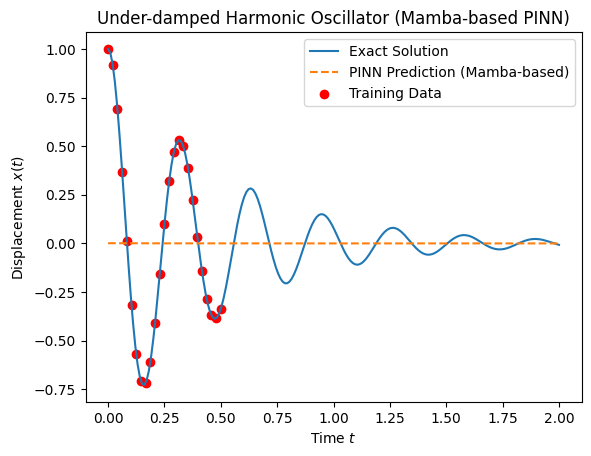

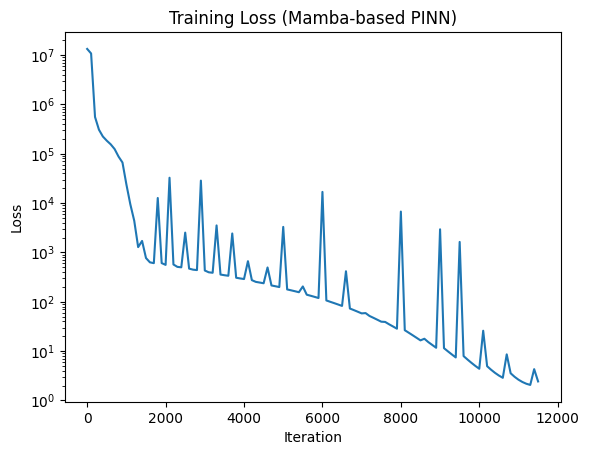

In [5]:
# Evaluate the model
params = model.get_params(model.opt_state)
t_test = jnp.linspace(0.0, 2.0, 200)
t_test = jnp.array(t_test)
net_apply = model.neural_net(params)
x_pred = vmap(net_apply)(t_test)
x_exact = oscillator(d, w0, t_test)

# Plot the results
plt.figure()
plt.plot(t_test, x_exact, label='Exact Solution')
plt.plot(t_test, x_pred, '--', label='PINN Prediction (Mamba-based)')
plt.scatter(t_data, x_data, color='red', label='Training Data')
plt.legend()
plt.xlabel('Time $t$')
plt.ylabel('Displacement $x(t)$')
plt.title('Under-damped Harmonic Oscillator (Mamba-based PINN)')
plt.show()

# Plot the training loss
plt.figure()
plt.plot(np.arange(len(model.loss_log))*100, model.loss_log)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Training Loss (Mamba-based PINN)')
plt.show()

## MAMBA SPINN

  5%|▌         | 5035/100000 [00:24<07:00, 225.58it/s]

[Epoch 5000] Loss = 2.14112e-01


 10%|█         | 10030/100000 [00:45<06:01, 248.76it/s]

[Epoch 10000] Loss = 2.48733e-01


 15%|█▌        | 15043/100000 [01:03<04:18, 329.18it/s]

[Epoch 15000] Loss = 2.07538e-01


 20%|██        | 20030/100000 [01:20<04:12, 317.21it/s]

[Epoch 20000] Loss = 1.44267e-01


 25%|██▌       | 25065/100000 [01:34<03:28, 359.06it/s]

[Epoch 25000] Loss = 1.43079e-01


 30%|███       | 30051/100000 [01:49<03:26, 338.58it/s]

[Epoch 30000] Loss = 1.41319e-01


 35%|███▌      | 35048/100000 [02:03<03:11, 339.22it/s]

[Epoch 35000] Loss = 1.20771e-01


 40%|████      | 40037/100000 [02:18<02:50, 351.78it/s]

[Epoch 40000] Loss = 1.77981e-02


 45%|████▌     | 45043/100000 [02:33<02:36, 350.13it/s]

[Epoch 45000] Loss = 1.60551e-02


 50%|█████     | 50046/100000 [02:47<02:19, 358.49it/s]

[Epoch 50000] Loss = 6.32470e-03


 55%|█████▌    | 55063/100000 [03:02<02:08, 349.47it/s]

[Epoch 55000] Loss = 5.98189e-03


 60%|██████    | 60034/100000 [03:16<01:59, 335.61it/s]

[Epoch 60000] Loss = 6.20956e-03


 65%|██████▌   | 65035/100000 [03:31<01:38, 353.29it/s]

[Epoch 65000] Loss = 6.26965e-03


 70%|███████   | 70056/100000 [03:45<01:26, 344.66it/s]

[Epoch 70000] Loss = 5.83958e-03


 75%|███████▌  | 75058/100000 [04:00<01:10, 352.34it/s]

[Epoch 75000] Loss = 5.95670e-03


 80%|████████  | 80039/100000 [04:16<01:11, 279.16it/s]

[Epoch 80000] Loss = 5.83549e-03


 85%|████████▌ | 85062/100000 [04:31<00:44, 333.62it/s]

[Epoch 85000] Loss = 4.42620e-03


 90%|█████████ | 90053/100000 [04:46<00:28, 349.78it/s]

[Epoch 90000] Loss = 7.32930e-04


 95%|█████████▌| 95071/100000 [05:04<00:14, 351.53it/s]

[Epoch 95000] Loss = 1.65944e-04


100%|██████████| 100000/100000 [05:21<00:00, 311.42it/s]


[Epoch 100000] Loss = 1.82858e-04
Training took 3.21 ms/iter
Relative L2 error ~ 1.55e-02


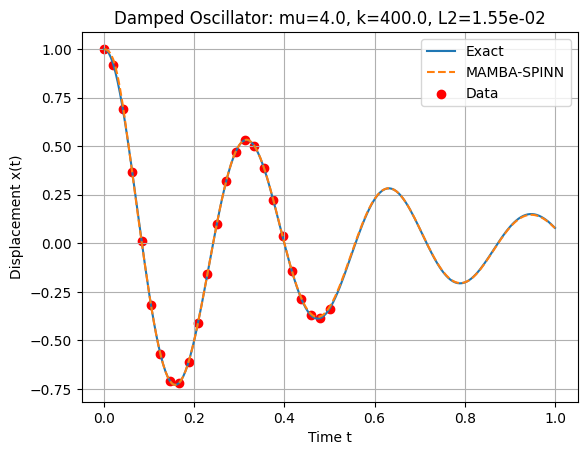

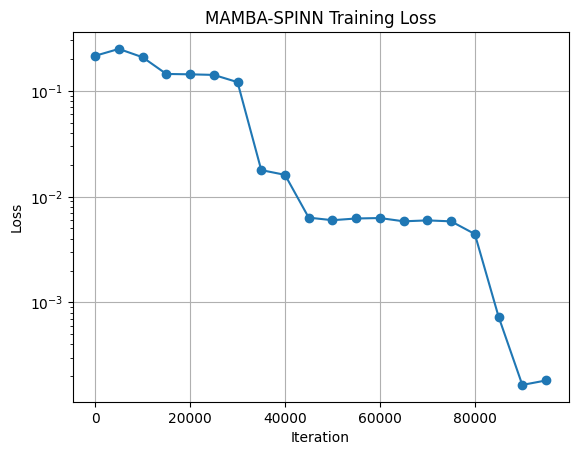

In [1]:
import os
import time
import math
import jax
import jax.numpy as jnp
import optax
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange
from jax import jvp, value_and_grad
from flax import linen as nn
from flax.linen.initializers import normal as flax_normal
from dataclasses import dataclass
from typing import Union, Sequence
from functools import partial

################################################################################
#                           Mamba-PINN ARCHITECTURE
################################################################################

@dataclass
class ModelArgs:
    """
    Adapt Mamba's arguments for a continuous input (e.g. time) -> single output.
    """
    d_model: int
    n_layer: int
    d_state: int = 16
    expand: int = 2
    dt_rank: Union[int, str] = 'auto'
    d_conv: int = 4
    conv_bias: bool = True
    bias: bool = False

    def __post_init__(self):
        self.d_inner = int(self.expand * self.d_model)
        if self.dt_rank == 'auto':
            self.dt_rank = math.ceil(self.d_model / 16)


class RMSNorm(nn.Module):
    d_model: int
    eps: float = 1e-5

    @nn.compact
    def __call__(self, x):
        weight = self.param('weight', nn.initializers.ones, (self.d_model,))
        normed = x * jax.lax.rsqrt(jnp.mean(x**2, axis=-1, keepdims=True) + self.eps)
        return normed * weight


class MambaBlock(nn.Module):
    args: ModelArgs

    def setup(self):
        self.in_proj = nn.Dense(
            features=self.args.d_inner * 2,
            kernel_init=flax_normal(),
            use_bias=self.args.bias
        )
        # Depthwise convolution
        self.conv1d = nn.Conv(
            features=self.args.d_inner,
            kernel_size=[self.args.d_conv],
            feature_group_count=self.args.d_inner,
            padding=self.args.d_conv - 1,
            use_bias=self.args.conv_bias
        )
        self.x_proj = nn.Dense(self.args.dt_rank + self.args.d_state * 2, use_bias=False)
        self.dt_proj = nn.Dense(self.args.d_inner, use_bias=True)

        # Parameter A_log, D
        A = jnp.tile(jnp.arange(1, self.args.d_state + 1), (self.args.d_inner, 1))
        self.A_log = self.param('A_log', lambda rng, shape: jnp.log(A),
                                (self.args.d_inner, self.args.d_state))
        self.D = self.param('D', nn.initializers.ones, (self.args.d_inner,))

        self.out_proj = nn.Dense(
            features=self.args.d_model,
            kernel_init=flax_normal(),
            use_bias=self.args.bias
        )

    def __call__(self, x):
        """
        x: (batch, length, d_model)
        Returns: (batch, length, d_model)
        """
        b, l, d = x.shape

        # in_proj => (b, l, 2*d_inner)
        x_and_res = self.in_proj(x)
        x_part, res = jnp.split(x_and_res, [self.args.d_inner], axis=-1)

        # Depthwise conv => (b, l, d_inner)
        x_part = self.conv1d(x_part)[:, :l, :]
        x_part = jax.nn.silu(x_part)

        # SSM forward
        y = self.ssm(x_part)

        # Gating
        y = y * jax.nn.silu(res)

        # Projection back to d_model
        out = self.out_proj(y)
        return out

    def ssm(self, x):
        """
        x: (b, l, d_inner)
        returns: (b, l, d_inner)
        """
        d_in, n = self.A_log.shape
        b, l, _ = x.shape

        A = -jnp.exp(self.A_log)
        D = self.D

        # x_proj => split => delta, B, C
        x_dbl = self.x_proj(x)
        delta, B, C = jnp.split(
            x_dbl,
            [self.args.dt_rank, self.args.dt_rank + n],
            axis=-1
        )
        # step sizes
        delta = jax.nn.softplus(self.dt_proj(delta))  # (b,l,d_in)

        return self.selective_scan(x, delta, A, B, C, D)

    def selective_scan(self, u, delta, A, B, C, D):
        """
        discrete state-space scan across time dimension
        u: (b,l,d_in)
        delta: (b,l,d_in)
        A: (d_in,n), B: (b,l,n), C: (b,l,n), D: (d_in,)
        """
        b, l, d_in = u.shape
        n = A.shape[1]

        # discretize
        deltaA = jnp.exp(jnp.einsum('bld,dn->bldn', delta, A))
        deltaB_u = jnp.einsum('bld,bln,bld->bldn', delta, B, u)

        x_state = jnp.zeros((b, d_in, n))
        ys = []
        for i in range(l):
            x_state = deltaA[:, i] * x_state + deltaB_u[:, i]
            y_i = jnp.einsum('bdn,bn->bd', x_state, C[:, i, :])
            ys.append(y_i)
        y = jnp.stack(ys, axis=1)  # => (b,l,d_in)
        # add skip
        y = y + u * D
        return y


class ResidualBlock(nn.Module):
    args: ModelArgs

    def setup(self):
        self.mixer = MambaBlock(self.args)
        self.norm = RMSNorm(self.args.d_model)

    def __call__(self, x):
        return self.mixer(self.norm(x)) + x


class MambaForPINNModel(nn.Module):
    """
    Minimal Mamba that accepts shape (b, l, input_dim) -> (b, l, 1).
    """
    args: ModelArgs
    input_dim: int = 1

    def setup(self):
        self.input_proj = nn.Dense(self.args.d_model)
        self.layers = [ResidualBlock(self.args) for _ in range(self.args.n_layer)]
        self.norm_final = RMSNorm(self.args.d_model)
        self.output_proj = nn.Dense(1)

    def __call__(self, x):
        # x: (b, l, input_dim)
        x = self.input_proj(x)
        for layer in self.layers:
            x = layer(x)
        x = self.norm_final(x)
        return self.output_proj(x)


def MambaForPINN(d_model=16, n_layer=2, input_dim=1):
    """
    Returns init_fn, apply_fn for the Mamba network.
    """
    args = ModelArgs(d_model=d_model, n_layer=n_layer)
    model = MambaForPINNModel(args, input_dim=input_dim)

    def init_fcn(rng_key):
        dummy_input = jnp.zeros((1, 1, input_dim))
        return model.init(rng_key, dummy_input)

    def apply_fcn(params, x):
        # x: shape (N, input_dim). Reshape => (N, 1, input_dim) for Mamba
        if x.ndim == 2:
            x_reshaped = x[:, None, :]
        else:
            x_reshaped = x.reshape(-1, 1, input_dim)
        y = model.apply(params, x_reshaped)  # => (N,1,1)
        return y.squeeze(axis=-1).squeeze(axis=-1)  # => shape (N,)

    return init_fcn, apply_fcn

################################################################################
#          SPINN CLASS (using Mamba-based architecture for 1D oscillator)
################################################################################

class MAMBA_SPINN_osc:
    """
    Simple class that holds the Mamba PINN for 1D damped oscillator,
    plus optimizer state. Not a Flax module, just a Python class.
    """
    def __init__(self, d_model=16, n_layer=2, lr=1e-3):
        # Create Mamba architecture
        self.init_fn, self.apply_fn = MambaForPINN(
            d_model=d_model,
            n_layer=n_layer,
            input_dim=1  # single dimension (time)
        )
        # Init params
        rng = jax.random.PRNGKey(0)
        self.params = self.init_fn(rng)
        # Setup optimizer
        self.optimizer = optax.adam(lr)
        self.opt_state = self.optimizer.init(self.params)

    def forward(self, t):
        """
        Evaluate the network for time array t, shape (N,).
        Returns (N,).
        """
        return self.apply_fn(self.params, t)

    def update_params(self, grads):
        updates, self.opt_state = self.optimizer.update(grads, self.opt_state)
        self.params = optax.apply_updates(self.params, updates)

################################################################################
#     HVP FORWARD-FORWARD: for computing second derivative wrt time in 1D
################################################################################

def hvp_fwdfwd_1d(f, primals, tangents, return_primals=False):
    """
    1D Hessian-vector product for PDE second derivative.
    """
    g = lambda p: jvp(f, (p,), tangents)[1]
    primals_out, tangents_out = jvp(g, primals, tangents)
    return (primals_out, tangents_out) if return_primals else tangents_out

################################################################################
#            Loss for damped oscillator PDE: x'' + mu x' + k x = 0
################################################################################

def spinn_loss_damped_oscillator(apply_fn, mu, k):
    """
    Return a function that computes PDE residual + initial + data losses.
    PDE: x_tt + mu x_t + k x = 0
    """
    def _pde_residual(params, t_c):
        # x(t)
        u = apply_fn(params, t_c)
        v = jnp.ones_like(t_c)  # for derivative
        def f(t):
            return apply_fn(params, t)

        # 1st derivative x'(t)
        x_t = jvp(f, (t_c,), (v,))[1]
        # 2nd derivative x''(t)
        x_tt = hvp_fwdfwd_1d(f, (t_c,), (v,))

        res = x_tt + mu * x_t + k * u
        return jnp.mean(res**2)

    def _initial_loss(params, t0):
        # x(0)=1, x'(0)=0
        x0 = apply_fn(params, t0)
        v = jnp.ones_like(t0)
        def f(t):
            return apply_fn(params, t)
        x0_t = jvp(f, (t0,), (v,))[1]
        return ((x0 - 1.0)**2 + (x0_t - 0.0)**2).sum()

    def _data_loss(params, t_d, x_d):
        pred = apply_fn(params, t_d)
        return jnp.mean((pred - x_d)**2)

    def loss_fn(params, t_c, t0, t_d, x_d):
        return 1e-4 * _pde_residual(params, t_c) \
             + _initial_loss(params, t0) \
             + _data_loss(params, t_d, x_d)

    return loss_fn

################################################################################
#                 Generate training data for the damped oscillator
################################################################################

def spinn_train_generator_damped_oscillator(n_colloc, n_data, T, mu, k, key):
    """
    Returns t_c, t0, t_d, x_d for PDE training:
      - t_c: collocation points in [0,T]
      - t0: array [0.] for initial condition
      - t_d, x_d: data points from exact solution
    """
    t_c = jax.random.uniform(key, (n_colloc,), minval=0.0, maxval=T)
    t0 = jnp.array([0.0])
    t_d = jnp.linspace(0, T/2, n_data)

    # exact solution
    d = mu / 2
    w0 = jnp.sqrt(k)
    def exact_solution(t):
        w = jnp.sqrt(w0**2 - d**2)
        phi = jnp.arctan(-d / w)
        A = 1.0 / (2.0 * jnp.cos(phi))
        return jnp.exp(-d*t)*2*A*jnp.cos(phi + w*t)

    x_d = exact_solution(t_d)
    return t_c, t0, t_d, x_d

################################################################################
#                   Main function: Training the MAMBA SPINN
################################################################################

def main_damped_oscillator(
    n_colloc=64,
    n_data=25,
    T=1.0,
    mu=4.0,
    k=20.0,
    seed=0,
    lr=1e-3,
    epochs=20000,
    n_layers=4,
    width=64,
    log_iter=2000
):
    """
    Example of training the 1D damped oscillator PDE with Mamba-based SPINN.
    """
    # fix GPU usage
    os.environ["CUDA_VISIBLE_DEVICES"] = "0"
    os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

    # 1) Build the MAMBA SPINN
    # We'll pass d_model=width, n_layer=n_layers, lr=lr, etc.
    model = MAMBA_SPINN_osc(d_model=width, n_layer=n_layers, lr=lr)

    # 2) Generate data
    key = jax.random.PRNGKey(seed)
    key, subkey = jax.random.split(key)
    t_c, t0, t_d, x_d = spinn_train_generator_damped_oscillator(n_colloc, n_data, T, mu, k, subkey)

    # 3) Build PDE loss
    loss_fn = spinn_loss_damped_oscillator(model.apply_fn, mu, k)

    @partial(jax.jit, static_argnums=(0,))
    def train_step(loss_f, params, opt_state):
        loss, grads = value_and_grad(loss_f)(params, t_c, t0, t_d, x_d)
        updates, opt_state = model.optimizer.update(grads, opt_state)
        params = optax.apply_updates(params, updates)
        return loss, params, opt_state

    # 4) Training loop
    losses = []
    tic = time.time()
    for i in trange(1, epochs+1):
        loss_val, model.params, model.opt_state = train_step(loss_fn, model.params, model.opt_state)
        if i % log_iter == 0:
            losses.append(float(loss_val))
            print(f"[Epoch {i}] Loss = {loss_val:.5e}")
    toc = time.time()
    print(f"Training took {(toc - tic)/epochs*1000:.2f} ms/iter")

    # 5) Evaluate final solution
    t_test = jnp.linspace(0.0, T, 200)
    x_pred = model.apply_fn(model.params, t_test)

    # exact solution
    d = mu / 2
    w0 = jnp.sqrt(k)
    def exact_solution(t):
        w = jnp.sqrt(w0**2 - d**2)
        phi = jnp.arctan(-d / w)
        A = 1.0/(2.0*jnp.cos(phi))
        return jnp.exp(-d*t)*2*A*jnp.cos(phi + w*t)

    x_exact = exact_solution(t_test)
    l2_rel = jnp.linalg.norm(x_pred - x_exact)/jnp.linalg.norm(x_exact)
    print(f"Relative L2 error ~ {l2_rel:.2e}")

    # 6) Plot results
    plt.figure()
    plt.plot(t_test, x_exact, label='Exact')
    plt.plot(t_test, x_pred, '--', label='MAMBA-SPINN')
    plt.scatter(t_d, x_d, color='red', label='Data')
    plt.xlabel('Time t')
    plt.ylabel('Displacement x(t)')
    plt.title(f"Damped Oscillator: mu={mu}, k={k}, L2={l2_rel:.2e}")
    plt.legend()
    plt.grid(True)
    plt.show()

    # plot losses
    plt.figure()
    iters_logged = np.arange(len(losses)) * log_iter
    plt.plot(iters_logged, losses, 'o-')
    plt.yscale('log')
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title("MAMBA-SPINN Training Loss")
    plt.grid(True)
    plt.show()

    return l2_rel


if __name__ == "__main__":
    # Example usage
    main_damped_oscillator(
        n_colloc=64,
        n_data=25,
        T=1.0,
        mu=4.0,
        k=400.0,
        seed=1234,
        lr=1e-3,
        epochs=100000,
        n_layers=1,
        width=16,
        log_iter=5000
    )


## KAN PINN

100%|██████████| 100000/100000 [01:37<00:00, 1020.69it/s, Loss=1.3859739e-05]


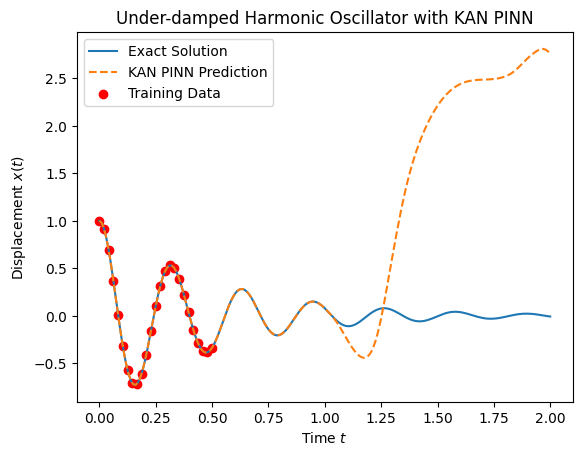

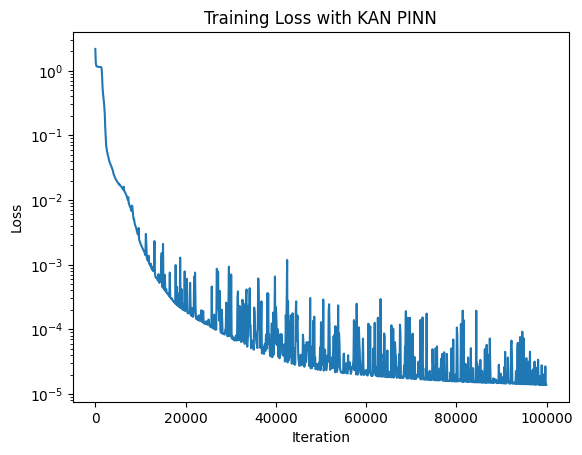

In [2]:
import numpy as np  # Original NumPy
import jax.numpy as jnp
from jax import random, grad, vmap, jit, value_and_grad
from jax.example_libraries import optimizers
from functools import partial
import matplotlib.pyplot as plt
from tqdm import trange
import itertools

# Import Flax modules
from flax import linen as nn

# Import the KAN model
from jaxkan.models.KAN import KAN


# Define the exact solution of the underdamped harmonic oscillator
def oscillator(d, w0, t):
    w = jnp.sqrt(w0 ** 2 - d ** 2)
    phi = jnp.arctan(-d / w)
    A = 1.0 / (2.0 * jnp.cos(phi))
    cos_term = jnp.cos(phi + w * t)
    exp_term = jnp.exp(-d * t)
    x = exp_term * 2 * A * cos_term
    return x

# Define the PINN model class using KAN
class PINN:
    def __init__(self, key, layers, mu, k):

        # Initialize the KAN model
        self.model = KAN(layer_dims=layers, add_bias=True)

        # Initialize parameters and state
        rng, init_rng = random.split(key)
        # Use a dummy ijnput to initialize the model
        x_init = jnp.array([[0.0]])  # Shape (1, 1)
        variables = self.model.init(init_rng, x_init)
        self.params = variables['params']
        self.state = variables.get('state', {})

        # Use optimizers to set optimizer initialization and update functions
        lr = optimizers.exponential_decay(1e-3, decay_steps=5000, decay_rate=0.90)
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(lr)
        self.opt_state = self.opt_init(self.params)

        # Logger
        self.itercount = itertools.count()

        self.loss_log = []

        # Constants
        self.mu = mu
        self.k = k

    def net_apply(self, params, x):
        outputs, _ = self.model.apply({'params': params, 'state': self.state}, x)
        return outputs.squeeze()  # Ensure output is a scalar

    def neural_net(self, params):
        # Define a function that can be differentiated
        def net_fn(t):
            x = t.reshape(-1, 1)
            return self.net_apply(params, x)
        return net_fn

    def residual_net(self, params):
        net_fn = self.neural_net(params)
        def res_fn(t):
            x = net_fn(t)
            x_t = grad(net_fn)(t)
            x_tt = grad(grad(net_fn))(t)
            residual = x_tt + self.mu * x_t + self.k * x
            return residual
        return res_fn

    @partial(jit, static_argnums=(0,))
    def loss(self, params, t_r, t_data, x_data):
        # Residual loss
        res_fn = self.residual_net(params)
        res = vmap(res_fn)(t_r)
        res_squared = res ** 2

        # Compute attention weights based on residuals (optional)
        weights = res_squared / jnp.sum(res_squared)
        loss_res = jnp.sum(weights * res_squared)

        # Or use unweighted residual loss
        # loss_res = jnp.mean(res_squared)

        # Data loss (at observed data points)
        net_fn = self.neural_net(params)
        x_pred = vmap(net_fn)(t_data)
        loss_data = jnp.mean((x_pred - x_data) ** 2)

        # Initial condition loss
        x0_pred = net_fn(jnp.array(0.0))
        x0_t_pred = grad(net_fn)(jnp.array(0.0))
        loss_ic = (x0_pred - 1.0) ** 2 + (x0_t_pred - 0.0) ** 2

        # Total loss
        total_loss = 1.e-4*loss_res + loss_data + loss_ic

        return total_loss

    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, t_r, t_data, x_data):
        params = self.get_params(opt_state)
        value, grads = value_and_grad(self.loss)(params, t_r, t_data, x_data)
        opt_state = self.opt_update(i, grads, opt_state)
        return opt_state, value

    def train(self, nIter, t_r, t_data, x_data):
        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            self.current_count = next(self.itercount)
            self.opt_state, loss_value = self.step(self.current_count, self.opt_state, t_r, t_data, x_data)

            if it % 100 == 0:
                self.loss_log.append(loss_value)
                pbar.set_postfix({'Loss': loss_value})

# Constants for the underdamped harmonic oscillator
d = 2.0
w0 = 20.0
mu = 2 * d
k = w0 ** 2

# Generate collocation points and data points
t_r = jnp.linspace(0.0, 1.0, 100)          # Collocation points for residual
t_data = jnp.linspace(0.0, 0.5, 25)        # Data points for initial training
x_data = oscillator(d, w0, t_data)        # Exact solution at data points

# Initialize the model
key = random.PRNGKey(0)
layers = [1, 25, 25, 1]  # Adjust the layers as needed
model = PINN(key, layers, mu, k)

# Convert data to appropriate types
t_r = jnp.array(t_r)
t_data = jnp.array(t_data)
x_data = jnp.array(x_data)

# Train the model
model.train(nIter=100000, t_r=t_r, t_data=t_data, x_data=x_data)

# Evaluate the model
params = model.get_params(model.opt_state)
t_test = jnp.linspace(0.0, 2.0, 200)
t_test = jnp.array(t_test)
net_fn = model.neural_net(params)
x_pred = vmap(net_fn)(t_test)
x_exact = oscillator(d, w0, t_test)

# Plot the results
plt.figure()
plt.plot(t_test, x_exact, label='Exact Solution')
plt.plot(t_test, x_pred, '--', label='KAN PINN Prediction')
plt.scatter(t_data, x_data, color='red', label='Training Data')
plt.legend()
plt.xlabel('Time $t$')
plt.ylabel('Displacement $x(t)$')
plt.title('Under-damped Harmonic Oscillator with KAN PINN')
plt.show()

# Plot the training loss
plt.figure()
plt.plot(np.arange(len(model.loss_log))*100, model.loss_log)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Training Loss with KAN PINN')
plt.show()


## ReLUKAN PINN

In [13]:



import numpy as np  # Original NumPy
import jax.numpy as jnp
from jax import random, grad, vmap, jit, value_and_grad
from jax.example_libraries import optimizers
from functools import partial
import matplotlib.pyplot as plt
from tqdm import trange
import itertools

# Import Flax modules
from flax import linen as nn

# Import the KAN model
from jaxkan.models.ReLUKAN import ReLUKAN


# Define the exact solution of the underdamped harmonic oscillator
def oscillator(d, w0, t):
    w = jnp.sqrt(w0 ** 2 - d ** 2)
    phi = jnp.arctan(-d / w)
    A = 1.0 / (2.0 * jnp.cos(phi))
    cos_term = jnp.cos(phi + w * t)
    exp_term = jnp.exp(-d * t)
    x = exp_term * 2 * A * cos_term
    return x

# Define the PINN model class using KAN
class PINN:
    def __init__(self, key, layers, mu, k):

        # Initialize the KAN model
        self.model = ReLUKAN(layer_dims=layers, add_bias=True)

        # Initialize parameters and state
        rng, init_rng = random.split(key)
        # Use a dummy ijnput to initialize the model
        x_init = jnp.array([[0.0]])  # Shape (1, 1)
        variables = self.model.init(init_rng, x_init)
        self.params = variables['params']
        self.state = variables.get('state', {})

        # Use optimizers to set optimizer initialization and update functions
        lr = optimizers.exponential_decay(1e-3, decay_steps=5000, decay_rate=0.90)
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(lr)
        self.opt_state = self.opt_init(self.params)

        # Logger
        self.itercount = itertools.count()

        self.loss_log = []

        # Constants
        self.mu = mu
        self.k = k

    def net_apply(self, params, x):
        outputs, _ = self.model.apply({'params': params, 'state': self.state}, x)
        return outputs.squeeze()  # Ensure output is a scalar

    def neural_net(self, params):
        # Define a function that can be differentiated
        def net_fn(t):
            x = t.reshape(-1, 1)
            return self.net_apply(params, x)
        return net_fn

    def residual_net(self, params):
        net_fn = self.neural_net(params)
        def res_fn(t):
            x = net_fn(t)
            x_t = grad(net_fn)(t)
            x_tt = grad(grad(net_fn))(t)
            residual = x_tt + self.mu * x_t + self.k * x
            return residual
        return res_fn

    @partial(jit, static_argnums=(0,))
    def loss(self, params, t_r, t_data, x_data):
        # Residual loss
        res_fn = self.residual_net(params)
        res = vmap(res_fn)(t_r)
        res_squared = res ** 2

        # Compute attention weights based on residuals (optional)
        weights = res_squared / jnp.sum(res_squared)
        loss_res = jnp.sum(weights * res_squared)

        # Or use unweighted residual loss
        # loss_res = jnp.mean(res_squared)

        # Data loss (at observed data points)
        net_fn = self.neural_net(params)
        x_pred = vmap(net_fn)(t_data)
        loss_data = jnp.mean((x_pred - x_data) ** 2)

        # Initial condition loss
        x0_pred = net_fn(jnp.array(0.0))
        x0_t_pred = grad(net_fn)(jnp.array(0.0))
        loss_ic = (x0_pred - 1.0) ** 2 + (x0_t_pred - 0.0) ** 2

        # Total loss
        total_loss = 1.e-4*loss_res + loss_data + loss_ic

        return total_loss

    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, t_r, t_data, x_data):
        params = self.get_params(opt_state)
        value, grads = value_and_grad(self.loss)(params, t_r, t_data, x_data)
        opt_state = self.opt_update(i, grads, opt_state)
        return opt_state, value

    def train(self, nIter, t_r, t_data, x_data):
        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            self.current_count = next(self.itercount)
            self.opt_state, loss_value = self.step(self.current_count, self.opt_state, t_r, t_data, x_data)

            if it % 100 == 0:
                self.loss_log.append(loss_value)
                pbar.set_postfix({'Loss': loss_value})

# Constants for the underdamped harmonic oscillator
d = 2.0
w0 = 20.0
mu = 2 * d
k = w0 ** 2

# Generate collocation points and data points
t_r = jnp.linspace(0.0, 1.0, 100)          # Collocation points for residual
t_data = jnp.linspace(0.0, 0.5, 25)        # Data points for initial training
x_data = oscillator(d, w0, t_data)        # Exact solution at data points

# Initialize the model
key = random.PRNGKey(0)
layers = [1, 1024, 1]  # Adjust the layers as needed
model = PINN(key, layers, mu, k)

# Convert data to appropriate types
t_r = jnp.array(t_r)
t_data = jnp.array(t_data)
x_data = jnp.array(x_data)

# Train the model
model.train(nIter=10000000, t_r=t_r, t_data=t_data, x_data=x_data)

# Evaluate the model
params = model.get_params(model.opt_state)
t_test = jnp.linspace(0.0, 2.0, 200)
t_test = jnp.array(t_test)
net_fn = model.neural_net(params)
x_pred = vmap(net_fn)(t_test)
x_exact = oscillator(d, w0, t_test)

# Plot the results
plt.figure()
plt.plot(t_test, x_exact, label='Exact Solution')
plt.plot(t_test, x_pred, '--', label='KAN PINN Prediction')
plt.scatter(t_data, x_data, color='red', label='Training Data')
plt.legend()
plt.xlabel('Time $t$')
plt.ylabel('Displacement $x(t)$')
plt.title('Under-damped Harmonic Oscillator with KAN PINN')
plt.show()

# Plot the training loss
plt.figure()
plt.plot(np.arange(len(model.loss_log))*100, model.loss_log)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Training Loss with KAN PINN')
plt.show()


  1%|          | 67676/10000000 [01:34<3:50:18, 718.75it/s, Loss=0.019916419]


KeyboardInterrupt: 

# High-level implementation

In [12]:
import numpy as np  # Original NumPy
import jax
import jax.numpy as jjnp
from jax import random, grad, vmap
import matplotlib.pyplot as plt
from tqdm import trange
import time

# Import Flax modules
from flax import linen as nn

# Import the KAN model
from jaxkan.models.KAN import KAN

# Import PIKAN functions (assuming PIKAN.py is in the same directory or installed as a module)
from jaxkan.utils.PIKAN import (
    gradf,  # Use the modified gradf function provided below
    get_vanilla_loss,
    get_adapt_loss,
    train_PIKAN,
    sobol_sample,
    interpolate_moments,
    state_transition,
)

# Define constants for the underdamped harmonic oscillator
d = 2.0
w0 = 20.0
mu = 2 * d
k = w0 ** 2
m = 1.0  # Assuming mass m = 1.0

# Define the exact solution function
def oscillator(d, w0, t):
    w = jjnp.sqrt(w0 ** 2 - d ** 2)
    phi = jjnp.arctan(-d / w)
    A = 1.0 / (2.0 * jjnp.cos(phi))
    cos_term = jjnp.cos(phi + w * t)
    exp_term = jjnp.exp(-d * t)
    x = exp_term * 2 * A * cos_term
    return x

# Modified gradf function for scalar functions
def gradf(f, order=1):
    '''
        Computes derivatives of arbitrary order for scalar functions of scalar ijnput.

        Args:
            f (function): function to be differentiated, scalar ijnput and scalar output
            order (int): derivative order

        Returns:
            g (function): derivative of f of specified order
    '''
    g = f
    for _ in range(order):
        g = jax.grad(g)
    return g

# Define the PDE loss function
def harmonic_oscillator_pde_loss(params, collocs, state):
    # collocs shape: (N_colloc, 1) for 1D ijnput (time)
    t = collocs[:, 0]  # Extract time points

    # Define the model function
    variables = {'params': params, 'state': state}

    def net_fn(t_scalar):
        x_ijnput = jjnp.array([[t_scalar]])  # Ensure x_ijnput has shape (1, n_in)
        y, _ = model.apply(variables, x_ijnput)
        return y.squeeze()

    # Compute the network predictions
    x = vmap(net_fn)(t)

    # Compute first and second derivatives with respect to time
    x_t = vmap(jax.grad(net_fn))(t)
    x_tt = vmap(gradf(net_fn, order=2))(t)

    # Compute the residuals of the ODE
    residuals = x_tt + mu * x_t + k * x

    return residuals.reshape(-1, 1)  # Ensure the residuals have shape (N_colloc, 1)

# Generate collocation points
N_colloc = 1000
t_min, t_max = 0.0, 2.0
collocs = jjnp.array(sobol_sample(np.array([t_min]), np.array([t_max]), N_colloc))

# Boundary collocation points (initial conditions)
bc_collocs = [
    jjnp.array([[0.0]]),  # For x(0)
    jjnp.array([[0.0]]),  # For dx/dt(0)
]

# Corresponding boundary data
bc_data = [
    jjnp.array([[1.0]]),  # x(0) = 1
    jjnp.array([[0.0]]),  # dx/dt(0) = 0
]

# Define the KAN model layer dimensions
layers = [1, 50, 50, 1]  # Adjust as needed

# Initialize the model
key = random.PRNGKey(0)
model = ReLUKAN(layer_dims=layers, add_bias=True)

# Initialize model variables
rng, init_rng = random.split(key)
x_init = jjnp.array([[0.0]])  # Dummy ijnput for initialization
variables = model.init(init_rng, x_init)

# Global weights for loss terms: [PDE loss weight, BC1 weight, BC2 weight]
glob_w = [1.0, 100.0, 100.0]  # Adjust weights as needed

# Learning rate scheduler parameters
lr_vals = {
    'init_lr': 1e-3,
    'scales': {1000: 0.5, 2000: 0.1},  # Learning rate decays at epochs 1000 and 2000
}

# Number of training epochs
num_epochs = 5000

# Whether to use adaptive loss weighting (RBA)
use_adaptive_loss = True  # Set True if you want to use RBA

# Local weights for adaptive loss (initialize to ones)
if use_adaptive_loss:
    loc_w = [
        jjnp.ones((N_colloc, 1)),  # For PDE residuals
        jjnp.ones((1, 1)),         # For x(0)
        jjnp.ones((1, 1)),         # For dx/dt(0)
    ]
else:
    loc_w = None

# Grid extension epochs and new grid sizes
grid_extend = {
    0: 3,  # At epoch 0, set grid size G_val = 3
}

# Grid adaptation epochs (if needed)
grid_adapt = []

# Collocation adaptation parameters (if needed)
colloc_adapt = {
    'epochs': [],  # List of epochs at which to resample collocation points
    'M': 2000,     # Number of points for resampling
    'k': 1.0,      # Parameter for RDA
    'c': 1.0,      # Parameter for RDA
}

# Train the model
model, variables, train_losses = train_PIKAN(
    model=model,
    variables=variables,
    pde_loss=harmonic_oscillator_pde_loss,
    collocs=collocs,
    bc_collocs=bc_collocs,
    bc_data=bc_data,
    glob_w=glob_w,
    lr_vals=lr_vals,
    adapt_state=True,
    loc_w=loc_w,
    nesterov=True,
    num_epochs=num_epochs,
    grid_extend=grid_extend,
    grid_adapt=grid_adapt,
    colloc_adapt=colloc_adapt
)

# Generate test points
t_test = jjnp.linspace(t_min, t_max, 200).reshape(-1)

# Define the model function using the trained variables
def net_fn(t_scalar):
    x_ijnput = jjnp.array([[t_scalar]])  # Ensure x_ijnput has shape (1, n_in)
    y, _ = model.apply(variables, x_ijnput)
    return y.squeeze()

# Compute predictions
x_pred = vmap(net_fn)(t_test)

# Compute exact solution
x_exact = oscillator(d, w0, t_test)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(t_test, x_exact, label='Exact Solution')
plt.plot(t_test, x_pred, '--', label='PIKAN Prediction')
plt.scatter(bc_collocs[0], bc_data[0], color='red', label='Training Data (IC)')
plt.legend()
plt.xlabel('Time $t$')
plt.ylabel('Displacement $x(t)$')
plt.title('Under-damped Harmonic Oscillator with PIKAN')
plt.show()

# Plot the training loss
plt.figure(figsize=(10, 6))
plt.plot(np.arange(num_epochs), train_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.yscale('log')
plt.title('Training Loss with PIKAN')
plt.show()


Epoch 0: Performing grid update



KeyboardInterrupt



# Progress study

In [7]:
# -------------------------------------------------------------
# Imports
# -------------------------------------------------------------

import numpy as np  # Original NumPy
import jax.numpy as jnp
from jax import random, grad, vmap, jit, value_and_grad
from jax.example_libraries import optimizers
from jax.flatten_util import ravel_pytree
from functools import partial
import matplotlib.pyplot as plt
from tqdm import trange
import itertools
import pandas as pd

# -------------------------------------------------------------
# Define the exact solution of the underdamped harmonic oscillator
# -------------------------------------------------------------

def oscillator(d, w0, t):
    w = jnp.sqrt(w0 ** 2 - d ** 2)
    phi = jnp.arctan(-d / w)
    A = 1.0 / (2.0 * jnp.cos(phi))
    cos_term = jnp.cos(phi + w * t)
    exp_term = jnp.exp(-d * t)
    x = exp_term * 2 * A * cos_term
    return x

# -------------------------------------------------------------
# Define the MLP function
# -------------------------------------------------------------

def MLP(layers, activation=jnp.tanh):
    def init(rng_key):
        def init_layer(key, d_in, d_out):
            k1, _ = random.split(key)
            glorot_stddev = 1.0 / jnp.sqrt((d_in + d_out) / 2.)
            W = glorot_stddev * random.normal(k1, (d_in, d_out))
            b = jnp.zeros(d_out)
            return W, b
        keys = random.split(rng_key, len(layers))
        params = list(map(init_layer, keys, layers[:-1], layers[1:]))
        return params

    def apply(params, inputs):
        H = inputs
        for W, b in params[:-1]:
            outputs = jnp.dot(H, W) + b
            H = activation(outputs)
        W, b = params[-1]
        outputs = jnp.dot(H, W) + b
        return outputs

    return init, apply

# -------------------------------------------------------------
# Define the PINN model class with time-dependent weighting
# -------------------------------------------------------------

class PINN:
    def __init__(self, key, layers, mu, k, activation, lambda_decay):

        # Initialize the neural network
        self.init, self.apply = MLP(layers, activation=activation)
        params = self.init(rng_key=key)
        _, self.unravel = ravel_pytree(params)

        # Use optimizers to set optimizer initialization and update functions
        lr = optimizers.exponential_decay(1e-3, decay_steps=5000, decay_rate=0.90)
        self.opt_init, \
        self.opt_update, \
        self.get_params = optimizers.adam(lr)
        self.opt_state = self.opt_init(params)

        # Logger
        self.itercount = itertools.count()
        self.loss_log = []

        # Constants
        self.mu = mu
        self.k = k

        # Decay rate for time-dependent weighting
        self.lambda_decay = lambda_decay  # Adjusted as a hyperparameter

    def neural_net(self, params):
        def net_apply(t):
            outputs = self.apply(params, t.reshape(-1, 1))
            return outputs.squeeze()  # Ensure output is a scalar
        return net_apply

    def residual_net(self, params):
        net_apply = self.neural_net(params)
        def res_apply(t):
            x = net_apply(t)
            x_t = grad(net_apply)(t)
            x_tt = grad(grad(net_apply))(t)
            residual = x_tt + self.mu * x_t + self.k * x
            return residual
        return res_apply

    @partial(jit, static_argnums=(0,))
    def loss(self, params, t_r, t_data, x_data):
        # Residual loss with time-dependent weighting
        res_apply = self.residual_net(params)
        residual_fn = vmap(res_apply)
        res = residual_fn(t_r)
        res_squared = res ** 2

        # Time-dependent weights
        weights_time = jnp.exp(-self.lambda_decay * t_r)
        weights_time /= jnp.sum(weights_time)  # Normalize weights

        # Apply weights to residual loss
        loss_res = jnp.sum(weights_time * res_squared)

        # Data loss (at observed data points)
        net_apply = self.neural_net(params)
        x_pred = vmap(net_apply)(t_data)
        loss_data = jnp.mean((x_pred - x_data) ** 2)

        # Initial condition loss
        x0_pred = net_apply(jnp.array(0.0))
        x0_t_pred = grad(net_apply)(jnp.array(0.0))
        loss_ic = (x0_pred - 1.0) ** 2 + (x0_t_pred - 0.0) ** 2

        # Total loss
        total_loss = 1.e-4 * loss_res + loss_data + loss_ic

        return total_loss

    @partial(jit, static_argnums=(0,))
    def step(self, i, opt_state, t_r, t_data, x_data):
        params = self.get_params(opt_state)
        value, grads = value_and_grad(self.loss)(params, t_r, t_data, x_data)
        opt_state = self.opt_update(i, grads, opt_state)
        return opt_state, value

    def train(self, nIter, t_r, t_data, x_data):
        pbar = trange(nIter)
        # Main training loop
        for it in pbar:
            self.current_count = next(self.itercount)
            self.opt_state, loss_value = self.step(self.current_count, self.opt_state, t_r, t_data, x_data)

            if it % 100 == 0:
                self.loss_log.append(loss_value)
                pbar.set_postfix({'Loss': loss_value})

# -------------------------------------------------------------
# Constants for the underdamped harmonic oscillator
# -------------------------------------------------------------

d = 2.0
w0 = 20.0
mu = 2 * d
k = w0 ** 2

# -------------------------------------------------------------
# Experiment Setup
# -------------------------------------------------------------

# Define the number of experiments
NUM_EXPERIMENTS = 50  # Adjust as needed
LAYERS = [1, 256, 256, 256, 256, 1]  # Number of neurons in each layer
ACTIVATION_FUNCTION = jax.nn.gelu  # Activation function for the neural network
TIME_DECAY = 0.1  # Decay rate for time-dependent weighting

# Define hyperparameter ranges
LAMBDA_DECAY_RANGE = (0.1, 5.0)  # Decay rate for time-dependent weighting
NOISE_LEVEL_RANGE = (0.0, 0.1)  # Noise level in data
TRAINING_EPOCHS = 10000  # Number of training iterations

# Initialize a list to store results
experiment_results = []

# Set up collocation points and data points (same for all experiments)
t_r = jnp.linspace(0.0, 1.0, 100)          # Collocation points for residual
t_data = jnp.linspace(0.0, 0.5, 25)        # Data points for initial training
x_data_exact = oscillator(d, w0, t_data)   # Exact solution at data points

# Convert data to appropriate types
t_r = jnp.array(t_r)
t_data = jnp.array(t_data)
x_data_exact = jnp.array(x_data_exact)

# Optionally, add noise to data
def add_noise(x, noise_level, key):
    key, subkey = random.split(key)
    noise = noise_level * random.normal(subkey, shape=x.shape)
    return x + noise

# Experimental loop
for exp_num in range(NUM_EXPERIMENTS):
    print(f"\nStarting experiment {exp_num + 1}/{NUM_EXPERIMENTS}")

    # Random key for this experiment
    key = random.PRNGKey(exp_num)
    keys = random.split(key, 5)

    # Sample hyperparameters
    noise_level_exp = random.uniform(keys[4], minval=NOISE_LEVEL_RANGE[0], maxval=NOISE_LEVEL_RANGE[1])

    # Add noise to data if noise_level_exp > 0
    x_data = add_noise(x_data_exact, noise_level_exp, key)

    # Initialize the model
    model_key = random.PRNGKey(exp_num + 1000)  # Different key for model initialization
    model = PINN(
        key=model_key,
        layers=LAYERS,
        mu=mu,
        k=k,
        activation=ACTIVATION_FUNCTION,
        lambda_decay=TIME_DECAY
    )

    # Train the model
    model.train(nIter=TRAINING_EPOCHS, t_r=t_r, t_data=t_data, x_data=x_data)

    # Evaluate the model
    params = model.get_params(model.opt_state)
    t_test = jnp.linspace(0.0, 2.0, 200)
    t_test = jnp.array(t_test)
    net_apply = model.neural_net(params)
    x_pred = vmap(net_apply)(t_test)
    x_exact = oscillator(d, w0, t_test)

    # Compute Mean Squared Error (MSE) over the test range
    mse = float(jnp.mean((x_exact - x_pred) ** 2))

    # Store results
    experiment_results.append({
        'Noise_Level': float(noise_level_exp),
        'MSE': mse
    })

    print(f"Experiment {exp_num + 1} completed. MSE: {mse}")

# Convert results to a DataFrame
results_df = pd.DataFrame(experiment_results)
print(results_df)

# -------------------------------------------------------------
# Statistical Analysis (Optional)
# -------------------------------------------------------------

# For example, perform a linear regression to see the effect of hyperparameters on MSE
import statsmodels.api as sm
from statsmodels.formula.api import ols

# Prepare the DataFrame for regression analysis
# Map activation functions to strings
results_df['Activation_Function'] = results_df['Activation_Function'].astype(str)

# Encode categorical variables
results_df_encoded = pd.get_dummies(results_df, columns=['Activation_Function'], drop_first=True)

# Log-transform MSE for better linearity
results_df_encoded['log_MSE'] = np.log(results_df_encoded['MSE'])

# Define the regression formula
formula = 'log_MSE ~ Layer_Size + Num_Hidden_Layers + Lambda_Decay + Noise_Level + Activation_Function_jax_nn_relu + Activation_Function_jax_nn_gelu'

# Fit the model
model = ols(formula, data=results_df_encoded).fit()

# Print the regression results
print(model.summary())



Starting experiment 1/50


100%|██████████| 10000/10000 [00:08<00:00, 1139.55it/s, Loss=0.00279316]  


Experiment 1 completed. MSE: 0.42326101660728455

Starting experiment 2/50


100%|██████████| 10000/10000 [00:07<00:00, 1363.57it/s, Loss=0.049513742]


Experiment 2 completed. MSE: 0.13694699108600616

Starting experiment 3/50


100%|██████████| 10000/10000 [00:07<00:00, 1330.97it/s, Loss=0.00076211104]


Experiment 3 completed. MSE: 0.8128791451454163

Starting experiment 4/50


100%|██████████| 10000/10000 [00:07<00:00, 1309.01it/s, Loss=0.005471059]


Experiment 4 completed. MSE: 0.12543949484825134

Starting experiment 5/50


  0%|          | 0/10000 [00:03<?, ?it/s]


KeyboardInterrupt: 

# chat gpt question formulation

ok great now lets upgrade our implementation. bellow are the contents of a file called PIKAN.py (referring to physics-informed (PI) KAN)

```python
import jax
import jax.numpy as jjnp
from jax import vmap

import optax
from flax import linen as nn

from scipy.stats.qmc import Sobol
import numpy as jnp

import time


def interpolate_moments(mu_old, nu_old, new_shape):
    '''
        Performs a linear interpolation to assign values to the first and second-order moments of gradients
        of the c_i basis functions coefficients after grid extension
        Note:
            num_basis = G+k for splines and G+1 for R basis functions
            new_num_basis = G'+k for splines and G'+1 for R basis functions
        
        Args:
        -----
            mu_old (jjnp.array): first-order moments before extension
                shape (n_in*n_out, num_basis)
            nu_old (jjnp.array): second-order moments before extension
                shape (n_in*n_out, num_basis)
            new shape (tuple): (n_in*n_out, new_num_basis)
        
        Returns:
        --------
            mu_new (jjnp.array): first-order moments after extension
                shape (n_in*n_out, new_num_basis)
            nu_new (jjnp.array): second-order moments after extension
                shape (n_in*n_out, new_num_basis)
    '''
    old_shape = mu_old.shape
    size = old_shape[0]
    old_j = old_shape[1]
    new_j = new_shape[1]
    
    # Create new indices for the second dimension
    old_indices = jjnp.linspace(0, old_j - 1, old_j)
    new_indices = jjnp.linspace(0, old_j - 1, new_j)

    # Vectorize the interpolation function for use with vmap
    interpolate_fn = lambda old_row: jjnp.interp(new_indices, old_indices, old_row)

    # Apply the interpolation function to each row using vmap
    mu_new = vmap(interpolate_fn)(mu_old)
    nu_new = vmap(interpolate_fn)(nu_old)
    
    return mu_new, nu_new


@jax.jit
def state_transition(old_state, variables):
    '''
        Performs the state transition for the optimizer after grid extension
        
        Args:
        -----
            old_state (tuple): collection of adam state and scheduler state before extension
            variables (dict): variables dict of KAN model
        
        Returns:
        --------
            new_state (tuple): collection of adam state and scheduler state after extension
    '''
    # Copy old state
    adam_count = old_state[0].count
    #adam_count = jjnp.array(0, dtype=jjnp.int32)
    adam_mu, adam_nu = old_state[0].mu, old_state[0].nu

    # Get all layer-related keys, so that we do not touch the other parameters
    layer_keys = {k for k in adam_mu.keys() if k.startswith('layers_')}

    for key in layer_keys:
        # Find the c_basis shape for this layer
        c_shape = variables['params'][key]['c_basis'].shape
        # Get new mu and nu
        mu_new, nu_new = interpolate_moments(adam_mu[key]['c_basis'], adam_nu[key]['c_basis'], c_shape)
        # Set them
        adam_mu[key]['c_basis'], adam_nu[key]['c_basis'] = mu_new, nu_new

    # Make new adam state
    adam_state = optax.ScaleByAdamState(adam_count, adam_mu, adam_nu)
    # Make new scheduler state
    extra_state = optax.ScaleByScheduleState(adam_count)
    # Make new total state
    new_state = (adam_state, extra_state)

    return new_state


def sobol_sample(X0, X1, N, seed=42):
    '''
        Performs Sobol sampling
        
        Args:
        -----
            X0 (jnp.ndarray): lower end of sampling region
                shape (dims,)
            X1 (jnp.ndarray): upper end of sampling region
                shape (dims,)
            N (int): number of points to sample
            seed (int): seed for reproducibility
        
        Returns:
        --------
            points (jnp.ndarray): sampled points
                shape (N,dims)
    '''
    dims = X0.shape[0]
    sobol_sampler = Sobol(dims, scramble=True, seed=seed)
    points = sobol_sampler.random_base2(int(jnp.log2(N)))
    points = X0 + points * (X1 - X0)
    
    return points


def gradf(f, idx, order=1):
    '''
        Computes gradients of arbitrary order
        
        Args:
        -----
            f (function): function to be differentiated
            idx (int): index of coordinate to differentiate
            order (int): gradient order
        
        Returns:
        --------
            g (function): gradient of f
    '''
    def grad_fn(g, idx):
        return lambda tx: jax.grad(lambda tx: jjnp.sum(g(tx)))(tx)[..., idx].reshape(-1,1)

    g = lambda tx: f(tx)
    
    for _ in range(order):
        g = grad_fn(g, idx)
        
    return g


def get_vanilla_loss(pde_loss, model, variables):
    '''
        Wrapper that returns the loss function for a vanilla PIKAN
        
        Args:
        -----
            pde_loss (function): loss function corresponding to the PDE
            model: model from the models module
            variables (dict): variables dict of KAN model
        
        Returns:
        --------
            vanilla_loss_fn (function): loss function for the PIKAN
    '''
    
    @jax.jit
    def vanilla_loss_fn(params, collocs, bc_collocs, bc_data, glob_w, loc_w, state):
        '''
            Loss function for a vanilla PIKAN
            
            Args:
            -----
                params (dict): trainable parameters of the model
                collocs (jjnp.array): collocation points for the PDE loss
                bc_collocs (List[jjnp.array]): list of collocation points for the boundary losses
                bc_data (List[jjnp.array]): list of data corresponding to bc_collocs
                glob_w (List[jjnp.array]): global weights for each loss function's term
                loc_w (NoneType): placeholder to ensure a uniform train_step()
                state (dict): non-trainable parameters of the model
                
            Returns:
            --------
                total_loss (float): the loss function's value
                None (NoneType): placeholder to ensure a uniform train_step()
        '''     
        # Calculate PDE loss
        pde_res = pde_loss(params, collocs, state)
        total_loss = glob_w[0]*jjnp.mean((pde_res)**2)
        
        # Define the model function
        variables = {'params' : params, 'state' : state}
        
        def u(vec_x):
            y, spl = model.apply(variables, vec_x)
            return y
            
        # Boundary Losses
        for idx, colloc in enumerate(bc_collocs):
            # Residual = Model's prediction - Ground Truth
            residual = u(colloc) - bc_data[idx]
            # Loss
            total_loss += glob_w[idx+1]*jjnp.mean((residual)**2)

        # return a tuple to be the same as adaptive_loss_fn and thus be able
        # to define a common train step
        return total_loss, None
        
    return vanilla_loss_fn


def get_adapt_loss(pde_loss, model, variables):
    '''
        Wrapper that returns the loss function for an adaptive PIKAN
        
        Args:
        -----
            pde_loss (function): loss function corresponding to the PDE
            model: model from the models module
            variables (dict): variables dict of KAN model
        
        Returns:
        --------
            adaptive_loss_fn (function): loss function for the PIKAN
    '''
    
    @jax.jit
    def adaptive_loss_fn(params, collocs, bc_collocs, bc_data, glob_w, loc_w, state):
        '''
            Loss function for an adaptive PIKAN
            
            Args:
            -----
                params (dict): trainable parameters of the model
                collocs (jjnp.array): collocation points for the PDE loss
                bc_collocs (List[jjnp.array]): list of collocation points for the boundary losses
                bc_data (List[jjnp.array]): list of data corresponding to bc_collocs
                glob_w (List[jjnp.array]): global weights for each loss function's term
                loc_w (List[jjnp.array]): local RBA weights for each loss function's term
                state (dict): non-trainable parameters of the model
                
            Returns:
            --------
                total_loss (float): the loss function's value
                loc_w (List[jjnp.array]): updated RBA weights based on residuals
        '''
        # Loss parameter
        eta = jjnp.array(0.0001, dtype=float)
        # Placeholder list for RBA weights
        new_loc_w = []
    
        # Calculate PDE loss
        pde_res = pde_loss(params, collocs, state)
        
        # New RBA weights
        abs_res = jjnp.abs(pde_res)
        loc_w_pde = ((jjnp.array(1.0)-eta)*loc_w[0]) + ((eta*abs_res)/jjnp.max(abs_res))
        new_loc_w.append(loc_w_pde)
        
        # Weighted Loss
        total_loss = glob_w[0]*jjnp.mean((loc_w_pde*pde_res)**2)
    
        # Define the model function
        variables = {'params' : params, 'state' : state}
        
        def u(vec_x):
            y, spl = model.apply(variables, vec_x)
            return y
    
        # Boundary Losses
        for idx, colloc in enumerate(bc_collocs):
            # Residual = Model's prediction - Ground Truth
            bc_res = u(colloc) - bc_data[idx]
            # New RBA weight
            abs_res = jjnp.abs(bc_res)
            loc_w_bc = ((jjnp.array(1.0)-eta)*loc_w[idx+1]) + ((eta*abs_res)/jjnp.max(abs_res))
            new_loc_w.append(loc_w_bc)
            # Weighted Loss
            total_loss += glob_w[idx+1]*jjnp.mean((loc_w_bc*bc_res)**2)
    
        return total_loss, new_loc_w

    return adaptive_loss_fn


def train_PIKAN(model, variables, pde_loss, collocs, bc_collocs, bc_data, glob_w, lr_vals, 
                adapt_state=True, loc_w=None, nesterov=True, num_epochs = 3001, grid_extend={0 : 3}, grid_adapt=[], colloc_adapt={'epochs':[], 'M':1000, 'k':1.0, 'c':1.0}):
    '''
        Training routine for a PIKAN
        
        Args:
        -----
            model: model from the models module
            variables (dict): dict containing the params and state dicts
            pde_loss (function): loss function corresponding to the PDE
            collocs (jjnp.array): collocation points for the PDE loss
            bc_collocs (List[jjnp.array]): list of collocation points for the boundary losses
            bc_data (List[jjnp.array]): list of data corresponding to bc_collocs
            glob_w (List[jjnp.array]): global weights for each loss function's term
            lr_vals (dict): dict containing information about the scheduler
            adapt_state (bool): boolean that determines if adaptive state transition is applied during grid extension
            loc_w (List[jjnp.array]): local RBA weights for each loss function's term
            nesterov (bool): boolean that determines if Nesterov momentum is used for Adam
            num_epochs (int): number of training epochs
            grid_extend (dict): dict of epochs during which to perform grid extension and new values of G
            grid_adapt (List): list of epochs during which to perform grid adaptation
            colloc_adapt (dict): dict containing information about the RDA method
            
        Returns:
        --------
            model: trained model
            variables (dict): dict containing the params and state dicts of the trained model
            train_losses (jjnp.array): values of the loss function per epoch
                shape (num_epochs,)
    '''
    # Setup scheduler for optimizer
    scheduler = optax.piecewise_constant_schedule(
        init_value=lr_vals['init_lr'],
        boundaries_and_scales=lr_vals['scales']
    )
    # Initialize optimizer
    optimizer = optax.adam(learning_rate=scheduler, nesterov=nesterov)
    # Initialize optimizer state
    opt_state = optimizer.init(variables['params'])

    # Define loss function
    if loc_w is None:
        loss_fn = get_vanilla_loss(pde_loss, model, variables)
    else:
        loss_fn = get_adapt_loss(pde_loss, model, variables)

    # Define train loop
    @jax.jit
    def train_step(params, opt_state, collocs, bc_collocs, bc_data, glob_w, loc_w, state):
        
        (loss, loc_w), grads = jax.value_and_grad(loss_fn, has_aux=True)(params, collocs, bc_collocs, bc_data, glob_w, loc_w, state)
        
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        
        new_variables = {'params': params, 'state': state}
        
        return new_variables, opt_state, loss, loc_w

    # Check if we perform adaptive collocation points resampling
    if colloc_adapt['epochs']:
        # Define the function
        @jax.jit
        def resample_collocs(variables, collocs, sample, k=jjnp.array(1.0), c=jjnp.array(1.0)):
            # Calculate residuals of PDE
            resids = jjnp.abs(pde_loss(variables['params'], sample, variables['state']))
            # Raise to power k
            ek = jjnp.power(resids, k)
            # Divide by mean and add c
            px = (ek/jjnp.mean(ek)) + c
            # Normalize
            px_norm = (px / jjnp.sum(px))[:,0]
            # Draw ids for the sampled points using px_norm
            # Note that they key can be added as a function argument, for now there's no reason to
            X_ids = jax.random.choice(key=jax.random.PRNGKey(0), a=sample.shape[0], shape=(collocs.shape[0],), replace=False, p=px_norm)
            # Replace collocation points
            new_collocs = sample[X_ids]
        
            return new_collocs
    
        # Sample M points from Sobol
        M = colloc_adapt['M']
        sample = jjnp.array(sobol_sample(jnp.array([0,-1]), jnp.array([1,1]), M))
        # Draw k, c hyperparameters
        k, c = colloc_adapt['k'], colloc_adapt['c']

    # Initialize train_losses
    train_losses = jjnp.zeros((num_epochs,))

    # Start training
    start_time=time.time()
    G_val = grid_extend[0]
    
    for epoch in range(num_epochs):
        # Check if we have to adapt collocation points
        if epoch in colloc_adapt['epochs']:
            # Get new colloc points
            collocs = resample_collocs(variables, collocs, sample, k, c)
            # Restart training loc_w for the PDE if we're doing RBA
            if loc_w is not None:
                new_loc_w = jjnp.full_like(loc_w[0], jjnp.mean(loc_w[0]))
                loc_w[0] = new_loc_w
            # Adapt grid to new collocation points
            updated_variables = model.apply(variables, collocs, G_val, method=model.update_grids)
            variables = updated_variables.copy()
        # Check if we're in an update epoch
        if epoch in grid_adapt:
            updated_variables = model.apply(variables, collocs, G_val, method=model.update_grids)
            variables = updated_variables.copy()
        # Check if we're in an extension epoch
        if epoch in grid_extend.keys():
            print(f"Epoch {epoch}: Performing grid update")
            # Get grid size
            G_val = grid_extend[epoch]
            # Perform the update
            updated_variables = model.apply(variables, collocs, G_val, method=model.update_grids)
            variables = updated_variables.copy()
            # Optimizer Transition
            if adapt_state:
                opt_state = state_transition(opt_state, variables)
            else:
                opt_state = optimizer.init(variables['params'])
            
        # Calculate the loss
        params, state = variables['params'], variables['state']
        variables, opt_state, loss, loc_w  = train_step(params, opt_state, collocs, bc_collocs, bc_data, glob_w, loc_w, state)

        # Append the loss
        train_losses = train_losses.at[epoch].set(loss)

    # Calculate training time
    end_time = time.time()
    elapsed = end_time-start_time
    print(f"Total Time: {elapsed} s")
    print(f"Average time per iteration: {elapsed/num_epochs:.4f} s")
    
    return model, variables, train_losses
```
please restructure the harmonic oscillator code to be compatible for this PIKAN framework